# Zillow Clustering Project

#### Anna Vu (June 2021)



<br>

## Agenda

 - Executive Summary
 - Imports and Data Wrangling
 - Data Exploration
 - Modeling
 - Conclusion and Next Steps

<br>

## Executive Summary

Goals: Build a new regression model to predict logerror (log(Zestimate) - log(SalePrice)), and use clustering to see if we can find groups of similar observations to generate new features to be fed into our supervised model to have it perform better than the baseline.

What Actually Happened: I made some clusters that were statistically significant for difference in log error between them, but they didn't help my model. Even though I was told by recursive feature elimination that they wouldn't work, I still gave it benefit of the doubt. 

Clustering based on age, dollar per square foot, and number of bathrooms and bedrooms did not predict logerror well.

<br>

In [1]:
#imports
import os
import pandas as pd
from env import username, host, password 
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pythonfunctions.wrangle import get_zillow_data, prepare_zillow, train_validate_test_split, train_validate_test, impute_nulls, split_X_y, standard_scale_data, get_object_cols, get_numeric_X_cols  
from pythonfunctions.explore import explore_univariate, create_cluster, create_scatter_plot, get_zillow_heatmap

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score

## Data Wrangling

Acquire 2017 Zillow data from SQL, and turn it into a .csv for quicker use

In [2]:
#get our data, turn into .csv, and check shape
df = get_zillow_data()
df.shape

(77575, 68)

Takeaways:
 - Lots of missing values
 - Some columns have inaccurate content?
 - Let's just clean it up for now, and we'll decide what we want to explore on later

<br>

Prepare our data for mostly-ready use. We're going to rename columns, make dummies, create new features, drop outliers, and drop columns and rows with more than 50% missing values.

In [3]:
df = prepare_zillow(df)

We are going to split our data into train, validate, and test sets. Impute where we can, and drop the rest of the nulls.

In [4]:
#split into train, validate, test. Our target is logerror
train, validate, test = train_validate_test_split(df, 'logerror', seed=1349)

In [5]:
#return our train, validate, and test sets with calculatedbathnbr, fullbathcnt, regionidcity, regionidzip,censustractandblock
#imputed with most frequent values
train, validate, test = impute_nulls(train, validate, test, strategy='most_frequent', 
                        col_list=['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'censustractandblock'])

In [6]:
#return our train, validate, and test sets with finishedsquarefeet12, lotsizesquarefeet, structuretaxvaluedollarcnt, 
#tax_value, land tax value dollar count, and tax amount imputed with the column's median value. 
train, validate, test = impute_nulls(train, validate, test, strategy='median', 
                        col_list=['finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 
                                  'tax_value', 'landtaxvaluedollarcnt', 'tax_amount'])

In [7]:
#drop rows with remaining nulls from all of our split sets
train = train.dropna()
validate = validate.dropna()
test = test.dropna()

In [8]:
#assuring there are no more nulls and we can almost get to work
train.isna().sum().sum() + validate.isna().sum().sum() + test.isna().sum().sum()

0

In [9]:
#total rows and columns that are left to work with 
print (f' We now have {train.shape[0] + validate.shape[0] + test.shape[0]} rows, and {train.shape[1]} columns after preparing')

 We now have 49645 rows, and 47 columns after preparing


In [10]:
#split new train, validate, and test into X_train, y_train, X_validate, y_validate, X_test, y_test with logerror as our target
X_train, y_train, X_validate, y_validate, X_test, y_test = split_X_y(train, validate, test, 'logerror')

In [11]:
#get object columns, and numeric columns so we can scale our data
obj_cols = get_object_cols(X_train)
num_cols = get_numeric_X_cols(X_train, obj_cols)

In [12]:
#scale our X_train, X_validate, and X_test with standard scaler
X_train_scaled, X_validate_scaled, X_test_scaled = standard_scale_data(X_train[num_cols],X_validate[num_cols],X_test[num_cols])

Takeaways:
 - Our data is now clean, and split. 
 - We dropped any rows and columns with more than 50% missing values
 - Dropped, filled, or imputed for remaining missing values
 - We went from 77,575 rows to 49,645 rows.
 - We had 68 columns, now 47.

<br>

## Explore

Hypothesis List
 - - -  - - - - -

1.) Log error is affected by square footage, number of bedrooms and bathrooms.

2.) Log error is affected by property age

3.) Log error is affected by location

4.) Log error is affected by price per sq ft.

5.) Log error is affected by combinations of internal property features and combinations of locational features. 

#### Univariate Exploration

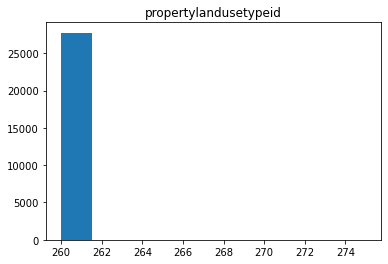

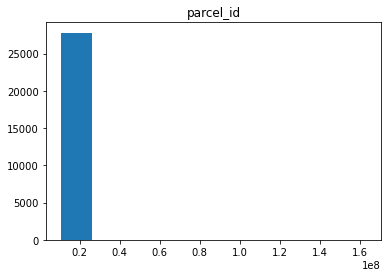

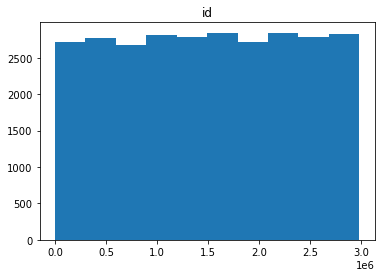

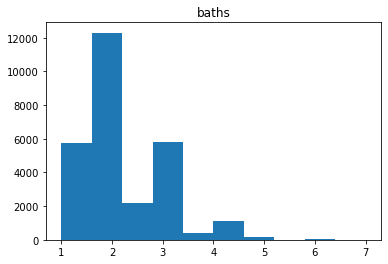

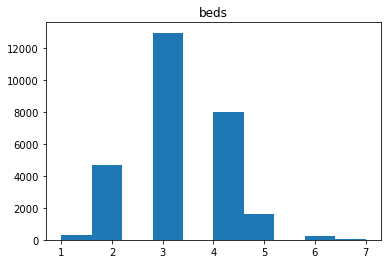

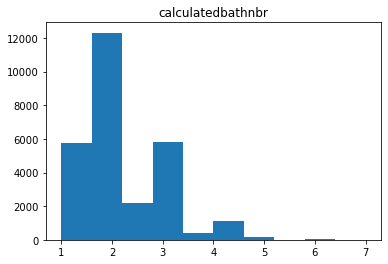

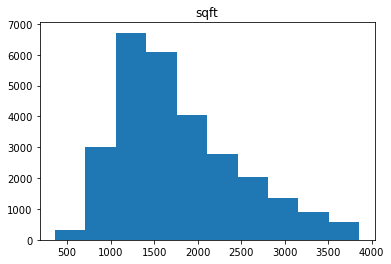

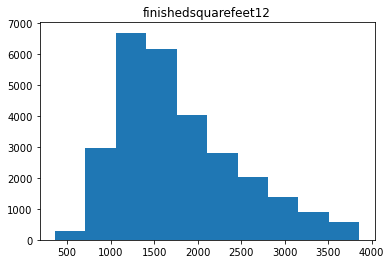

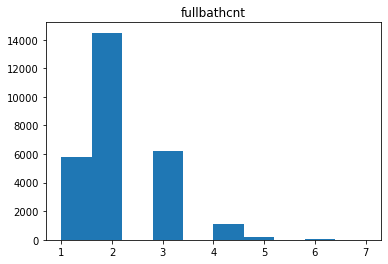

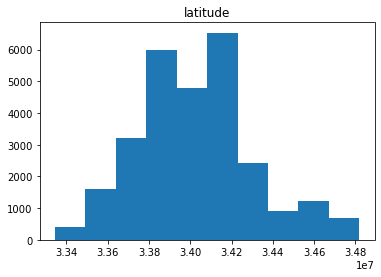

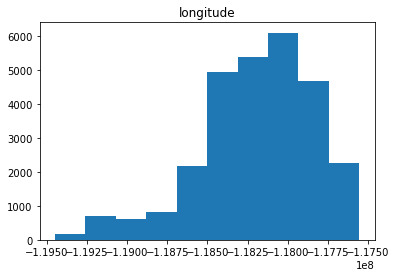

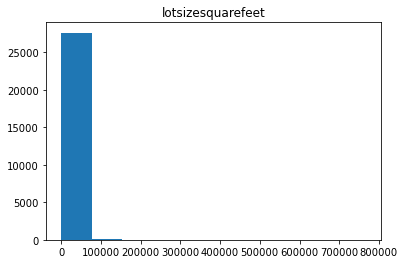

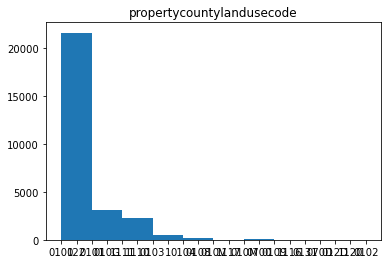

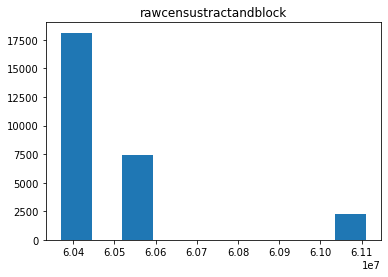

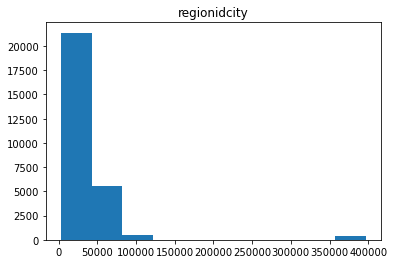

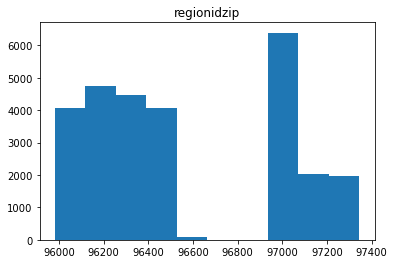

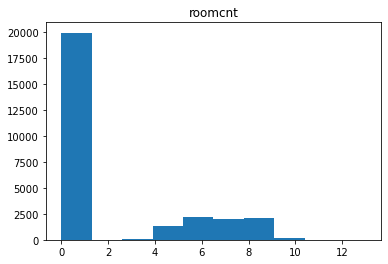

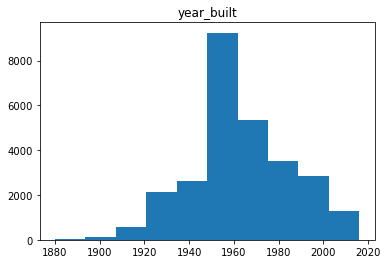

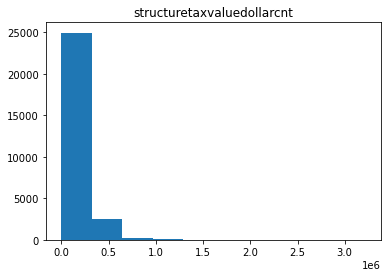

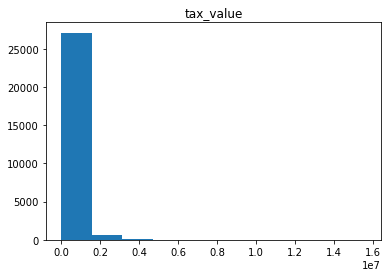

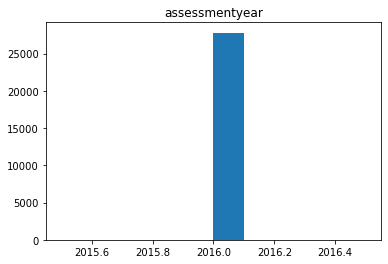

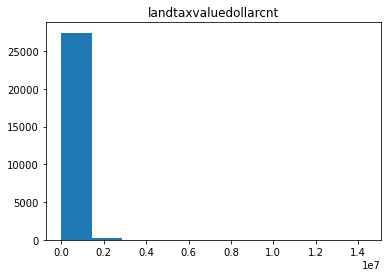

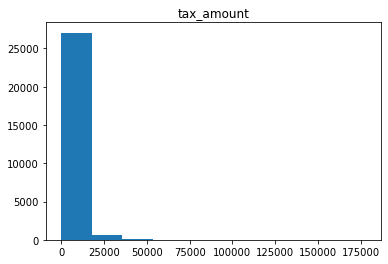

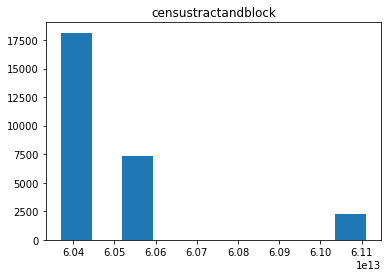

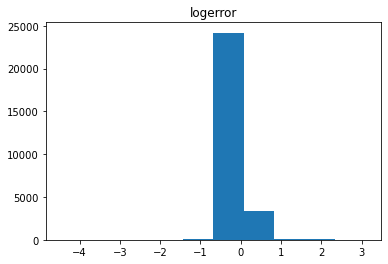

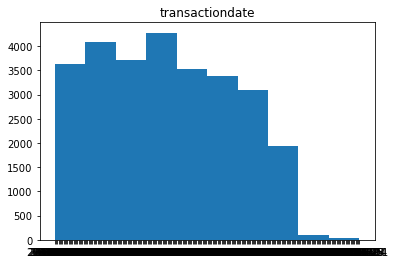

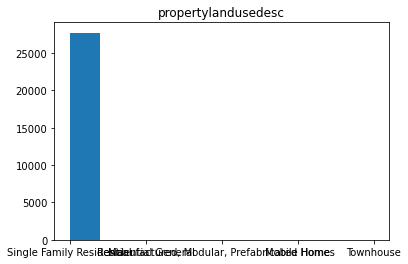

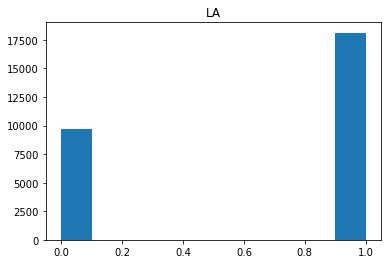

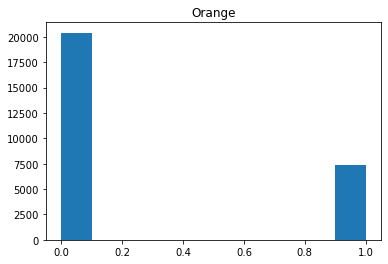

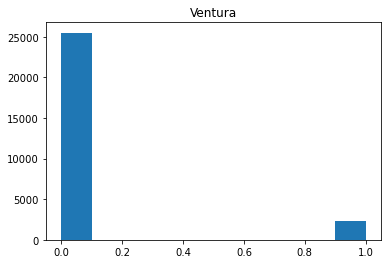

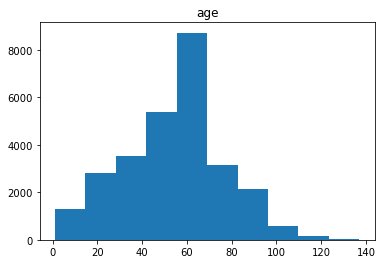

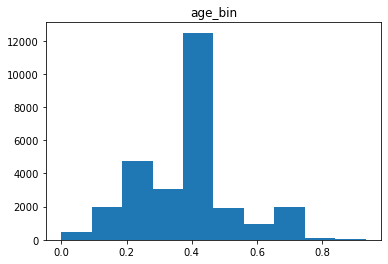

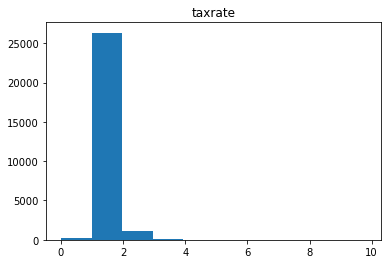

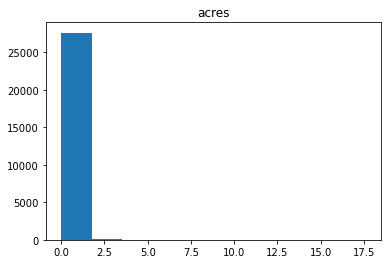

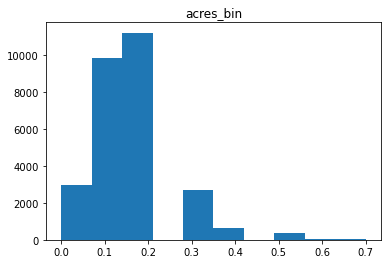

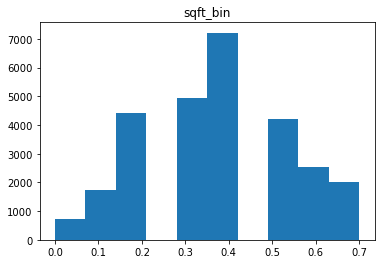

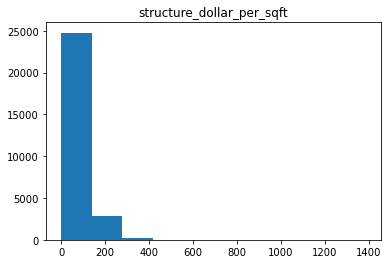

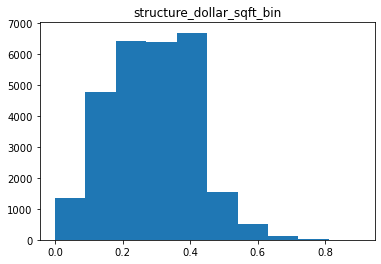

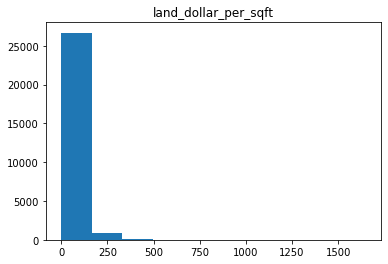

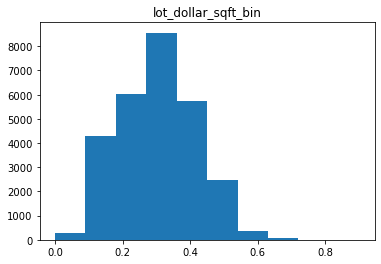

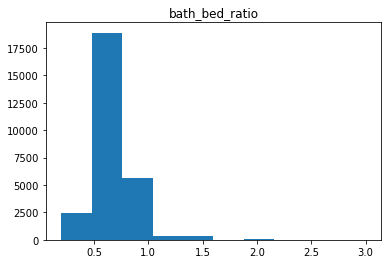

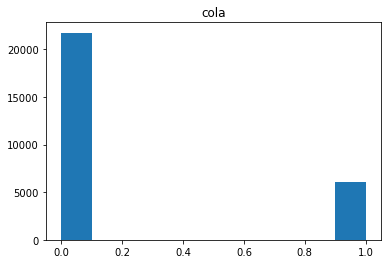

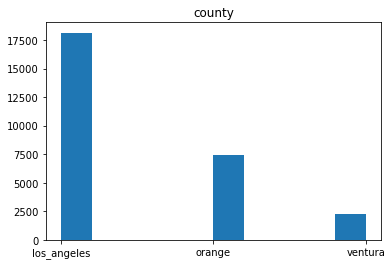

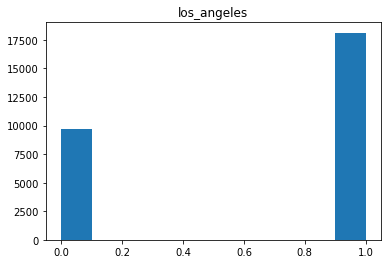

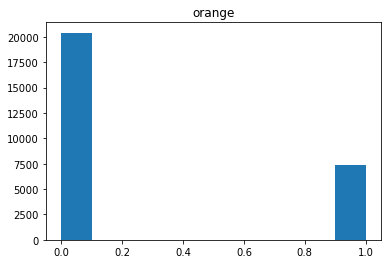

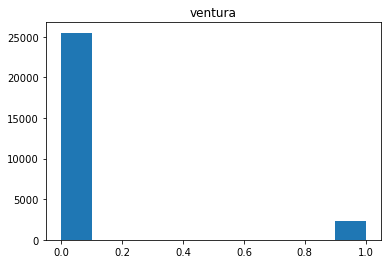

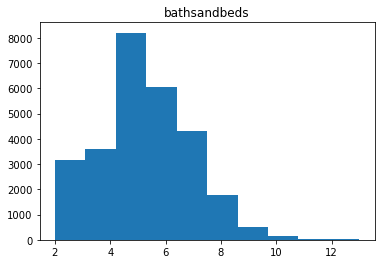

In [13]:
#univariate exploration
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### Closer Look at Univariate

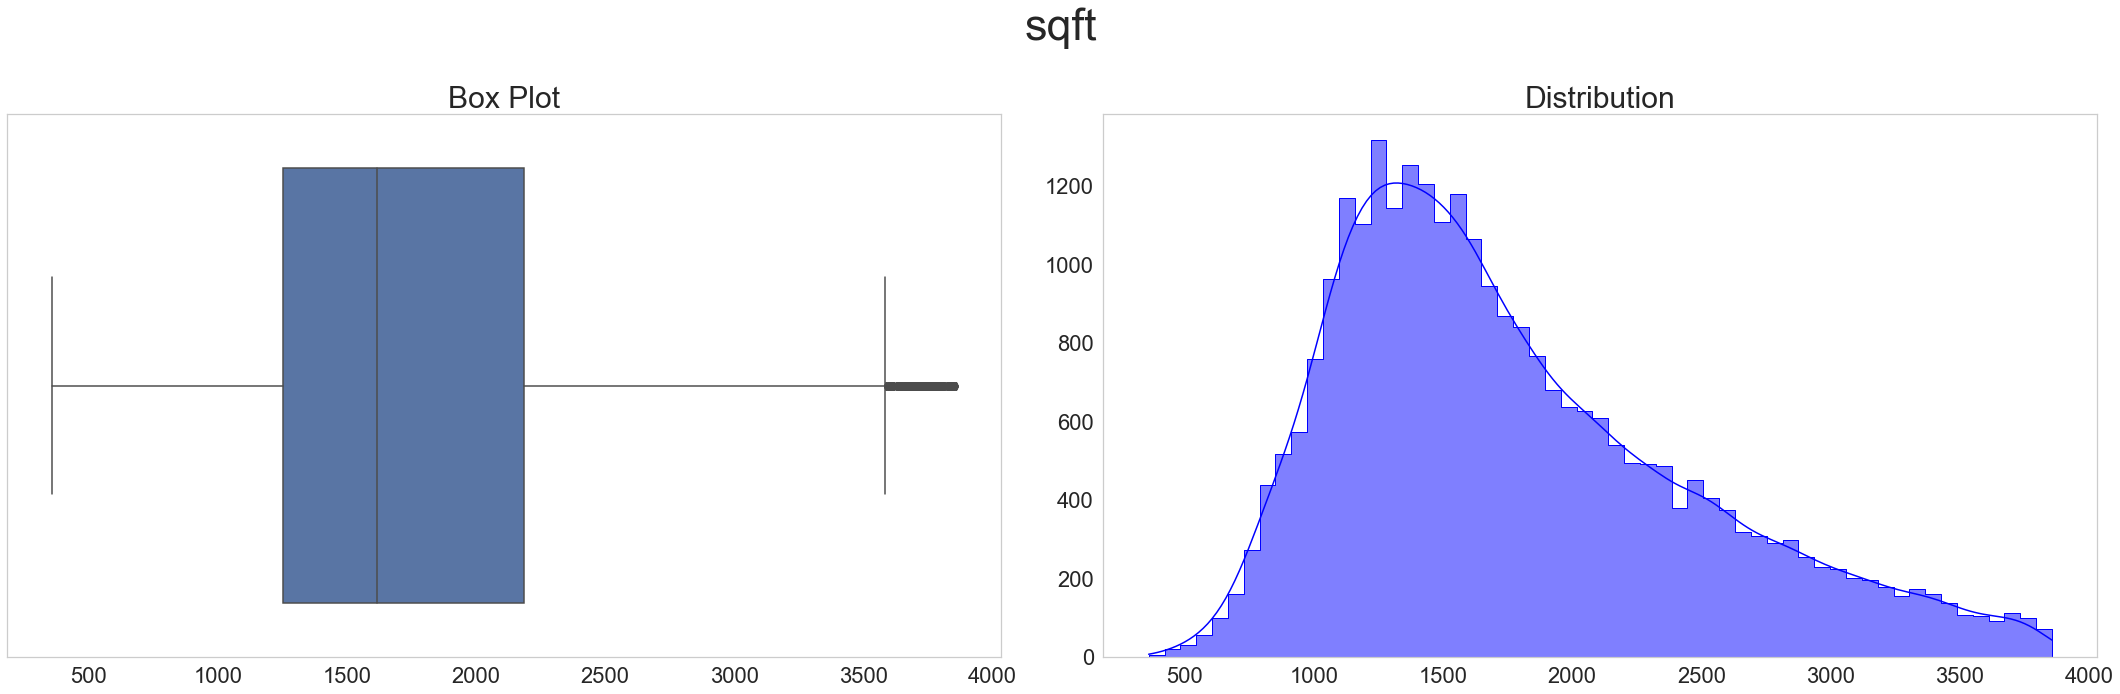

Summary Statistics for sqft
count    27798.000000
mean      1777.331750
std        695.137575
min        360.000000
25%       1253.000000
50%       1617.000000
75%       2186.000000
max       3857.000000
Name: sqft, dtype: float64


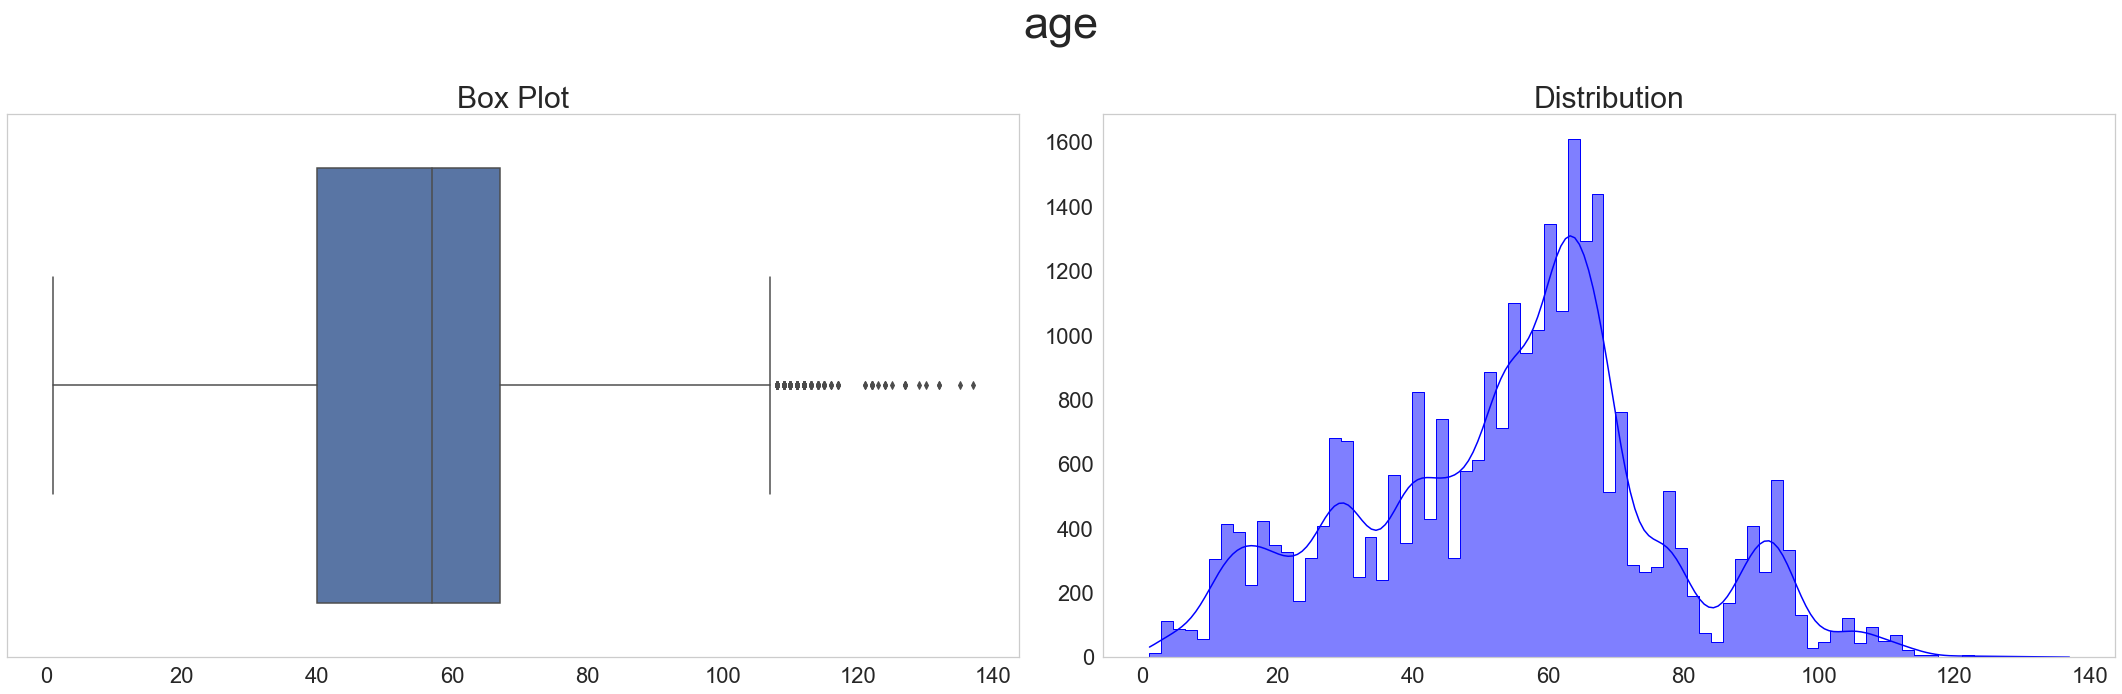

Summary Statistics for age
count    27798.000000
mean        54.711922
std         22.348823
min          1.000000
25%         40.000000
50%         57.000000
75%         67.000000
max        137.000000
Name: age, dtype: float64


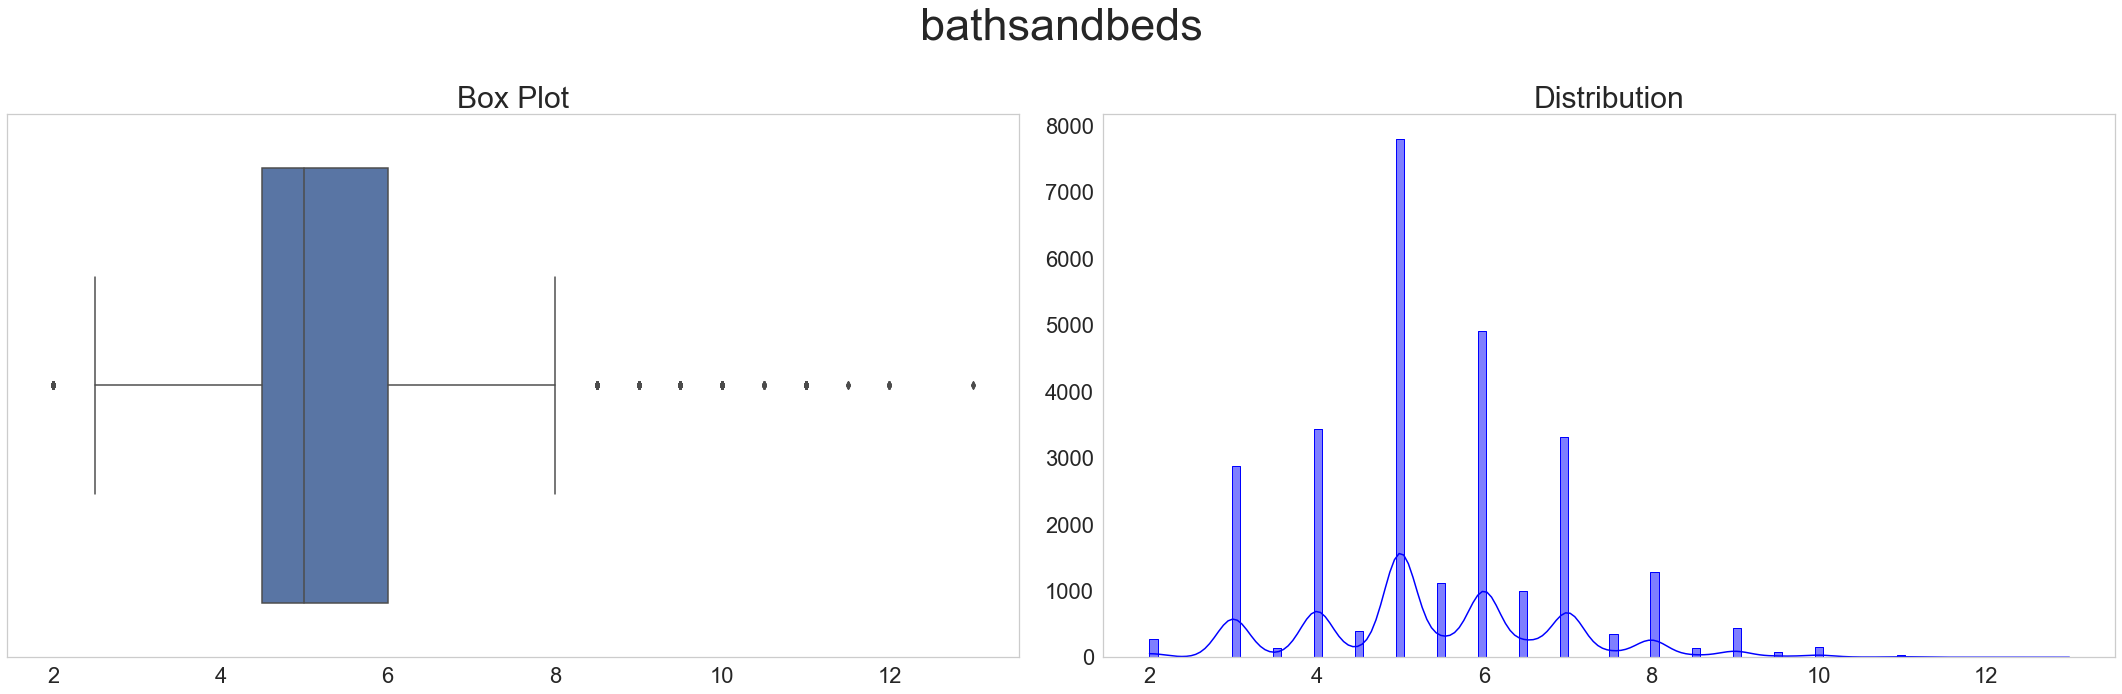

Summary Statistics for bathsandbeds
count    27798.000000
mean         5.421037
std          1.519852
min          2.000000
25%          4.500000
50%          5.000000
75%          6.000000
max         13.000000
Name: bathsandbeds, dtype: float64


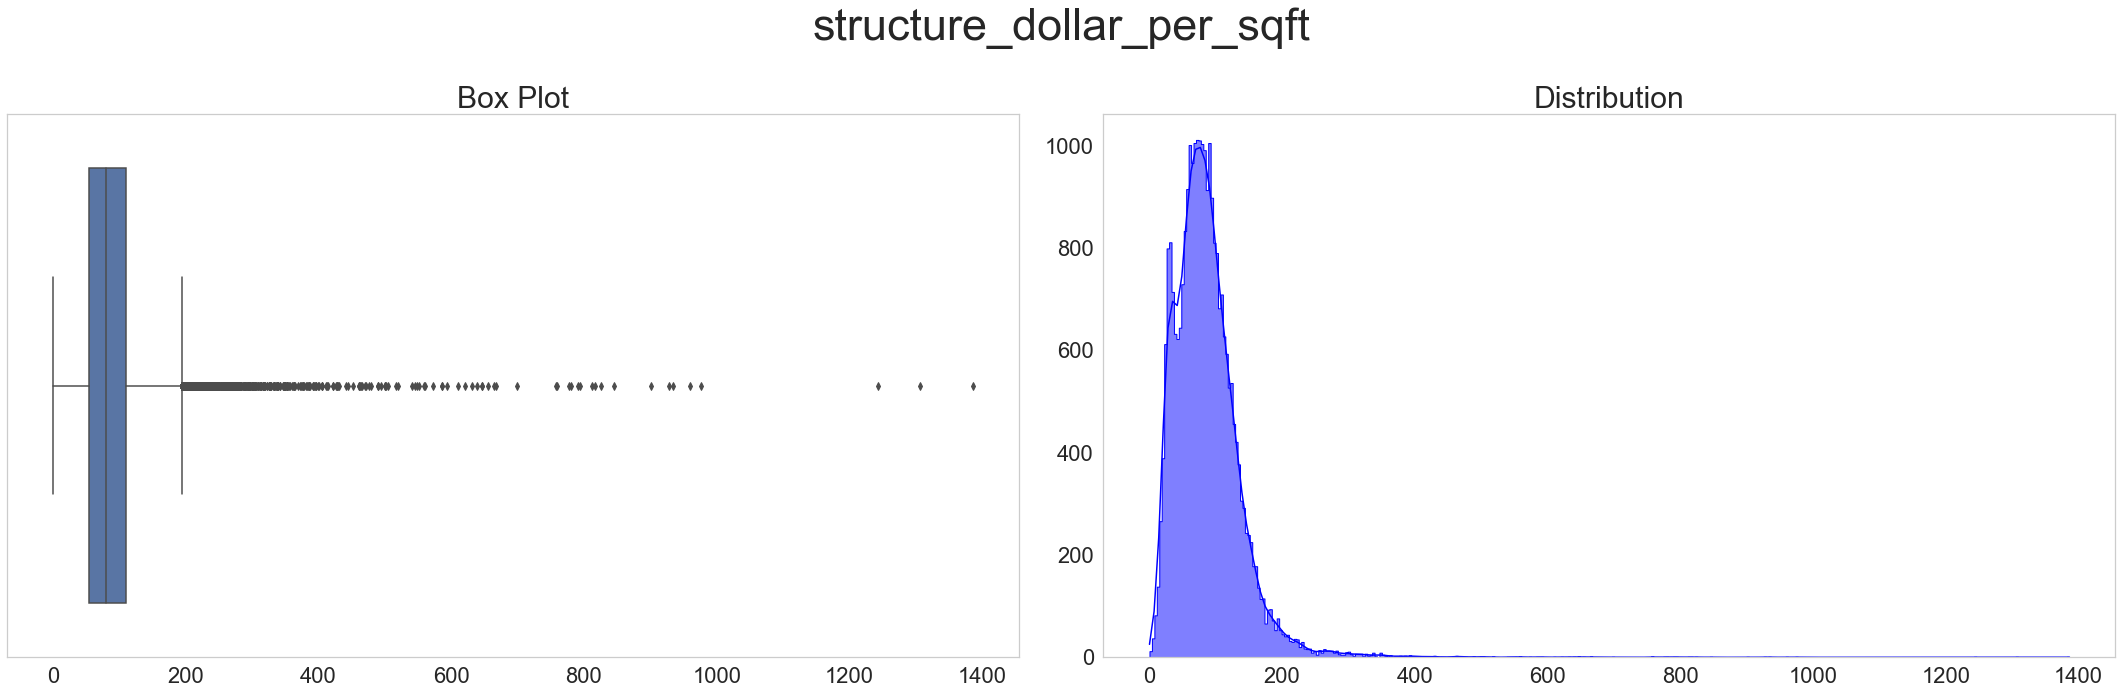

Summary Statistics for structure_dollar_per_sqft
count    27798.000000
mean        87.156388
std         54.826008
min          0.258741
25%         53.913315
50%         80.099439
75%        109.801895
max       1386.370588
Name: structure_dollar_per_sqft, dtype: float64


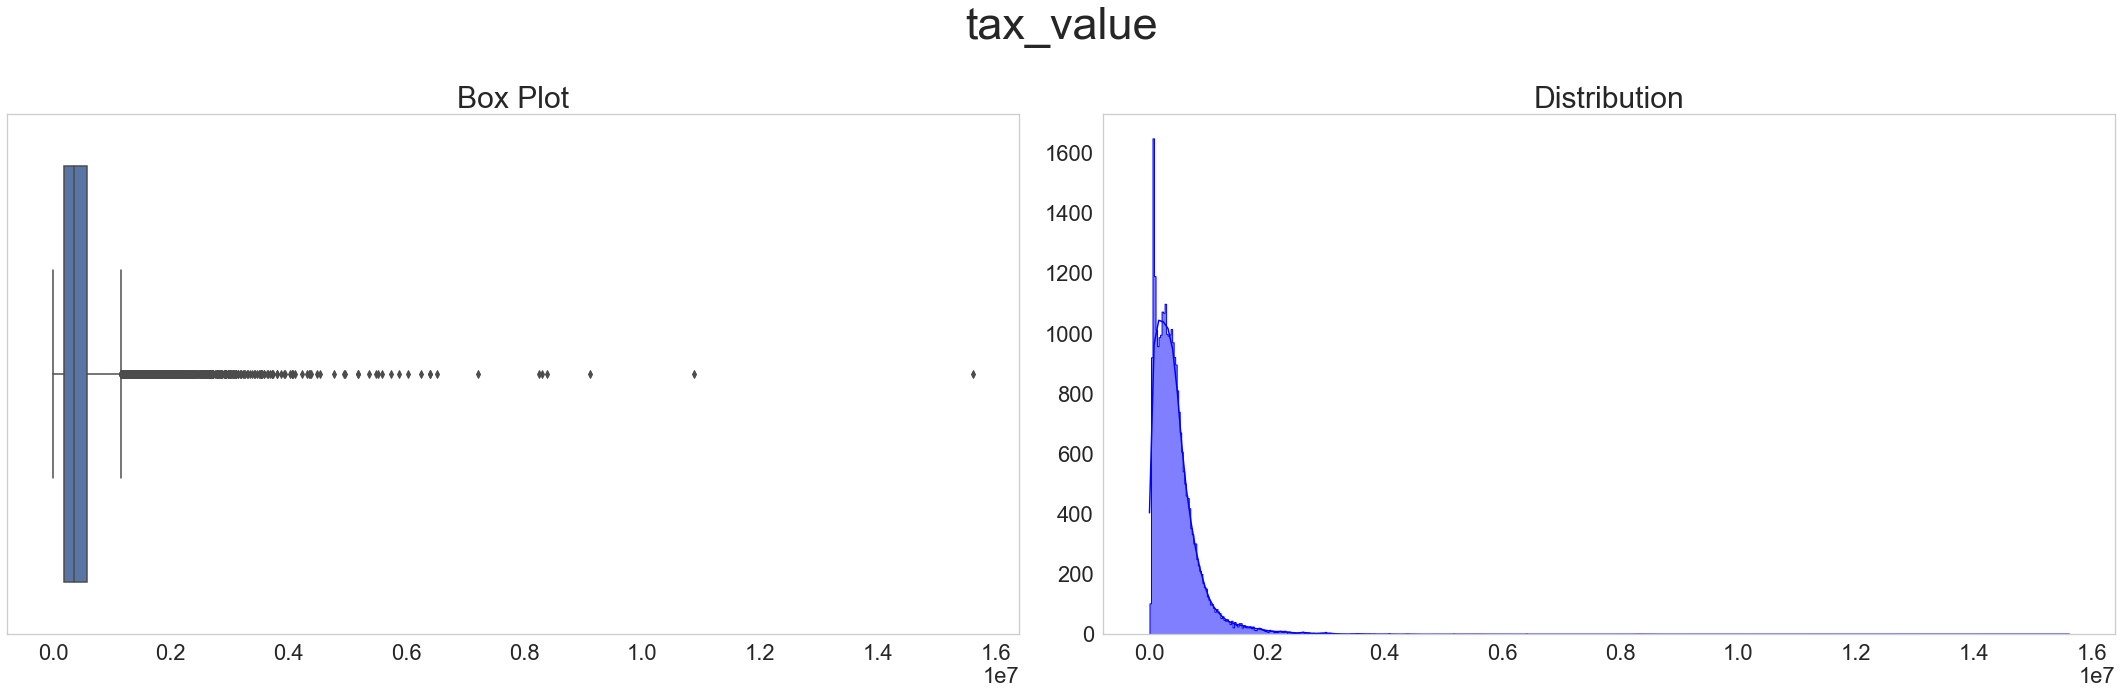

Summary Statistics for tax_value
count    2.779800e+04
mean     4.524594e+05
std      4.489882e+05
min      3.254000e+03
25%      1.861218e+05
50%      3.576760e+05
75%      5.750000e+05
max      1.561849e+07
Name: tax_value, dtype: float64


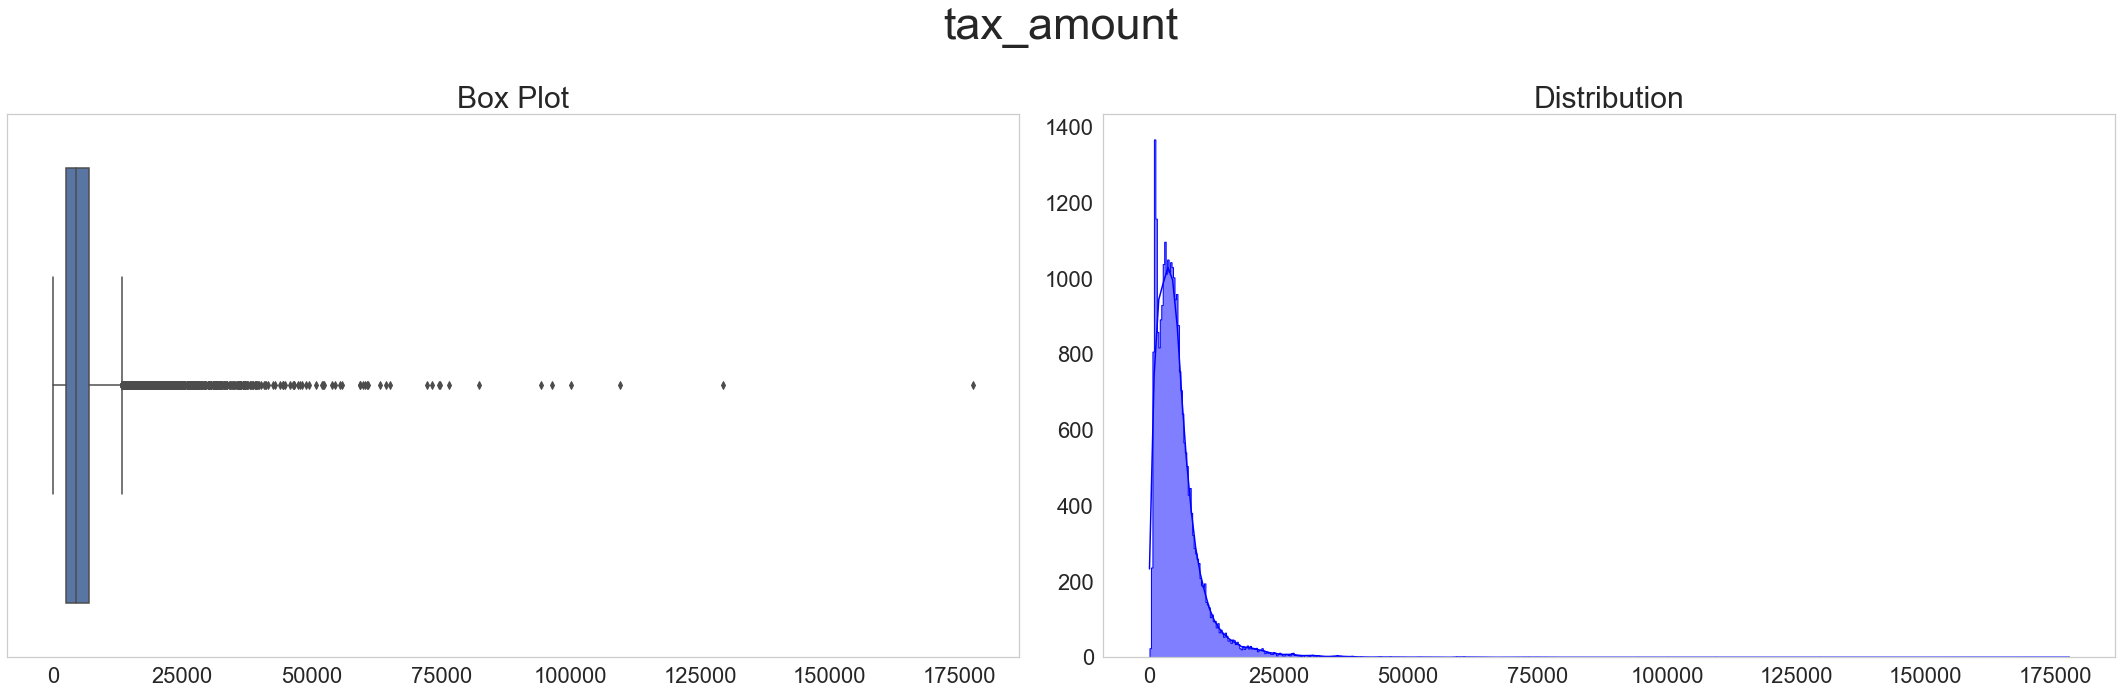

Summary Statistics for tax_amount
count     27798.000000
mean       5550.347738
std        5195.486416
min          49.180000
25%        2569.152500
50%        4464.095000
75%        6881.767500
max      177740.850000
Name: tax_amount, dtype: float64


In [14]:
#let's take a closer look at some of the features with boxplots, distributions, and summary statistics
univariate_stuff = ['sqft','age','bathsandbeds','structure_dollar_per_sqft','tax_value','tax_amount']

for i in univariate_stuff:
    explore_univariate(train, i)
    print(f'Summary Statistics for {i}\n{train[i].describe()}')

<br>

Takeaways for Univariate: 
 - Normal: number of bathrooms and bedrooms, latitude, and age
 - Skewed right: tax amount, tax value, $ per sqft
 - Skewed left: longitude

<br>

#### Bivariate Exploration

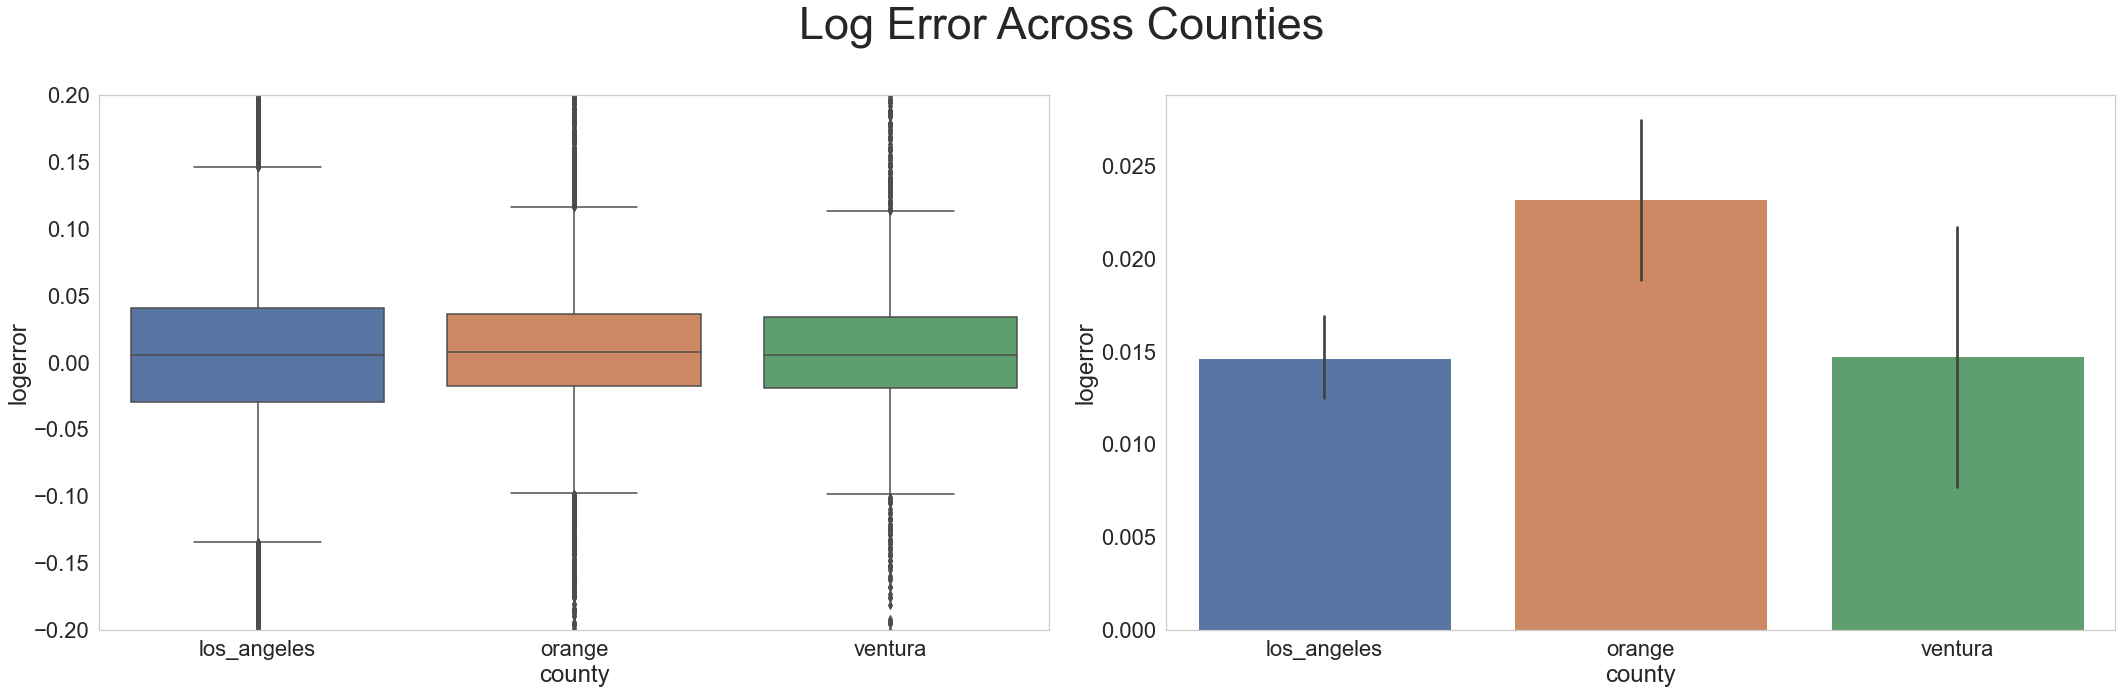

In [15]:
#logerror across counties (LA, Orange, and Ventura)

#set up figure size, font size, and turn off grid.
plt.figure(figsize=(30,10))
sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})

#boxplot
plt.subplot(1, 2, 1)
sns.boxplot(train.county, train.logerror)
plt.ylim(-.2, .2)

#barplot
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='county',y='logerror')

#title
plt.suptitle('Log Error Across Counties', fontsize = 45)
plt.tight_layout()
plt.show()

In [16]:
null_hypothesis = "no difference in logerror between orange county and the other counties"
alternative_hypothesis = "there is a difference in log error between orange county and other counties"
a = 0.05 #a for alpha 

orange_logerror=train[train.county=='orange'].logerror
other_logerror = train[train.county!='orange'].logerror
t, p = stats.ttest_ind(orange_logerror, other_logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between orange county and the other counties
There is evidence to suggest: there is a difference in log error between orange county and other counties


<br>

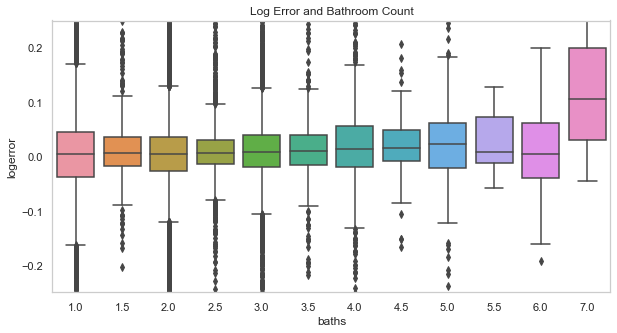

In [17]:
#Log error and number of bathrooms
plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.boxplot(train.baths, train.logerror)
plt.title('Log Error and Bathroom Count')
plt.ylim(-.25, .25)
plt.show()

In [18]:
null_hypothesis = "no difference in logerror between properties with 3 bathrooms or less, or more bathrooms"
alternative_hypothesis = "there is a difference in logerror between properties with 3 bathrooms or less, or more bathrooms"
a = 0.05 #a for alpha 

three_or_less_baths=train[train.baths<=3].logerror
more_than_three_baths = train[train.baths>3].logerror
t, p = stats.ttest_ind(three_or_less_baths, more_than_three_baths)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between properties with 3 bathrooms or less, or more bathrooms
There is evidence to suggest: there is a difference in logerror between properties with 3 bathrooms or less, or more bathrooms


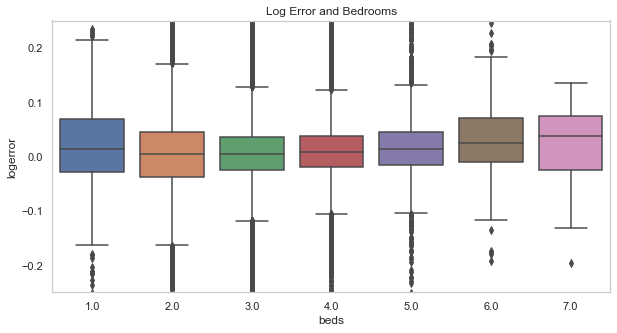

In [19]:
#log error and bedroom count
plt.figure(figsize=(10,5))
sns.set(font_scale = 1)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.boxplot(train.beds, train.logerror)
plt.title('Log Error and Bedrooms')
plt.ylim(-.25, .25)
plt.show()

In [20]:
null_hypothesis = "no difference in logerror between properties with 3 bedrooms or less, or more bedrooms"
alternative_hypothesis = "there is a difference in logerror between properties with 3 bedrooms or less, or more bedrooms"
a = 0.05 #a for alpha 

three_or_less_beds=train[train.beds<=3].logerror
more_than_three_beds = train[train.beds>3].logerror
t, p = stats.ttest_ind(three_or_less_beds, more_than_three_beds)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between properties with 3 bedrooms or less, or more bedrooms
There is evidence to suggest: there is a difference in logerror between properties with 3 bedrooms or less, or more bedrooms


Sqft and LogError


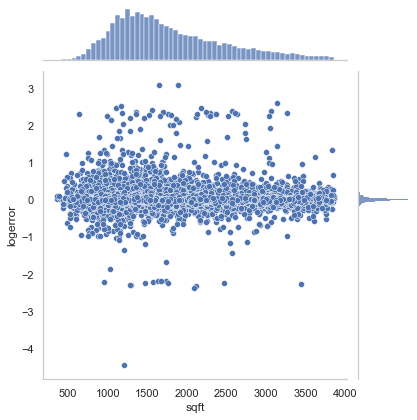

In [21]:
#Square footage and log error
print('Sqft and LogError')
sns.jointplot(x='sqft', y='logerror', data=train)
plt.xlabel('Sqft')
plt.ylabel('Log Error')
plt.show()

In [22]:
null_hypothesis = "no difference in logerror between properties 2000 sqft or less, or with more square footage"
alternative_hypothesis = "there is a difference in logerror between properties 2000 sqft or less, or with more square footage"
a = 0.05 #a for alpha 

big_house=train[train.sqft<=2000].logerror
small_house = train[train.sqft>2000].logerror
t, p = stats.ttest_ind(big_house, small_house)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between properties 2000 sqft or less, or with more square footage
There is evidence to suggest: there is a difference in logerror between properties 2000 sqft or less, or with more square footage


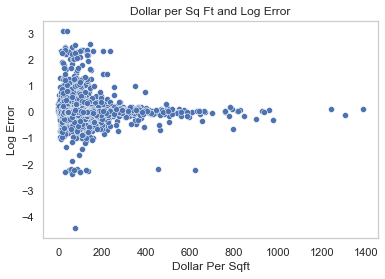

In [23]:
#Dollar/Sqft and Log Error
sns.scatterplot(x='structure_dollar_per_sqft', y='logerror', data=train)
plt.xlabel('Dollar Per Sqft')
plt.ylabel('Log Error')
plt.title('Dollar per Sq Ft and Log Error')
plt.show()

In [24]:
null_hypothesis = "no difference in logerror between dollar per sqft"
alternative_hypothesis = "there is a difference in logerror between dollar per sqft"
a = 0.05 #a for alpha 

corr, p = stats.pearsonr(train.structure_dollar_per_sqft,train.logerror)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: no difference in logerror between dollar per sqft
There is evidence to suggest: there is a difference in logerror between dollar per sqft


In [25]:
#let's add log error bins so we can check out a cool pairplot
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

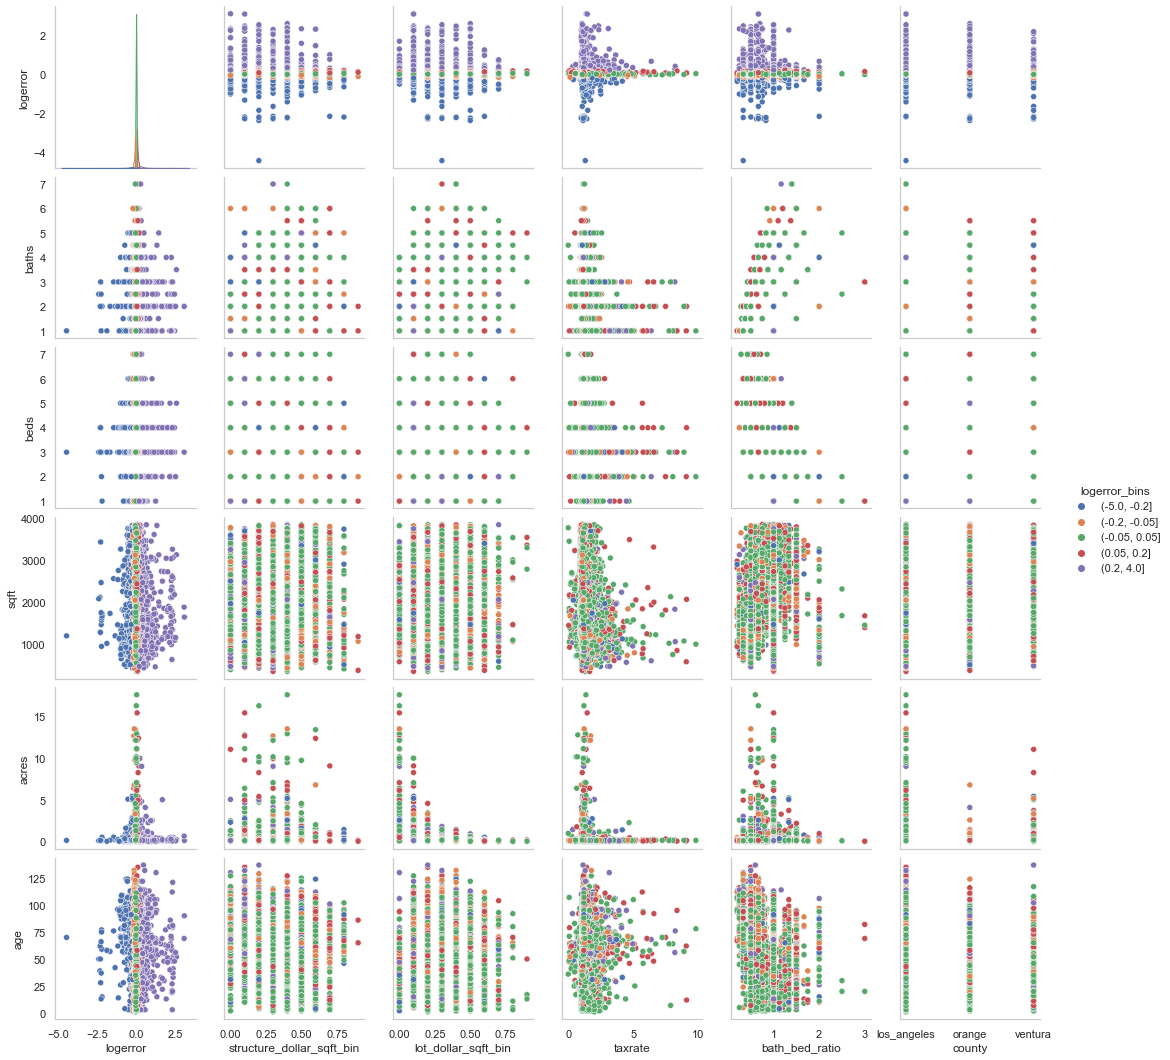

In [26]:
#the pairplot
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror','structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio','county'],
             y_vars = ['logerror', 'baths','beds', 'sqft', 'acres', 'age'])

<AxesSubplot:title={'center':'Feautures Correlating with Log Error'}>

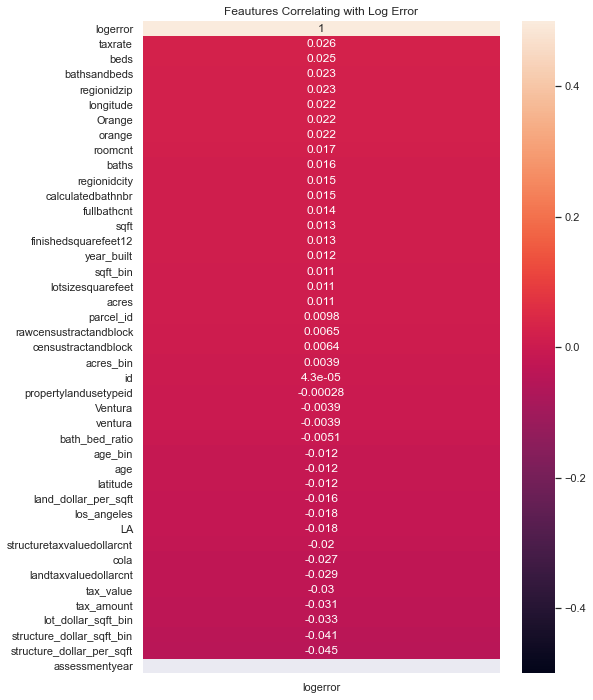

In [27]:
#let's look at a heatmap to see what features correlate with log error.
get_zillow_heatmap(train)

Takeaways: 
   - Log error is really diverse! 
   - No features are strongly correlated with log error

### Multivariate Exploration

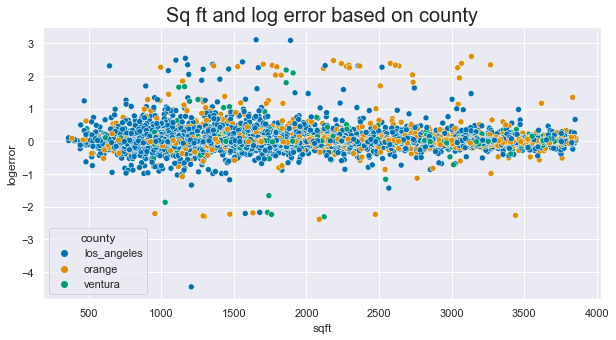

In [28]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='sqft',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Sq ft and log error based on county', fontsize = 20)
plt.show()

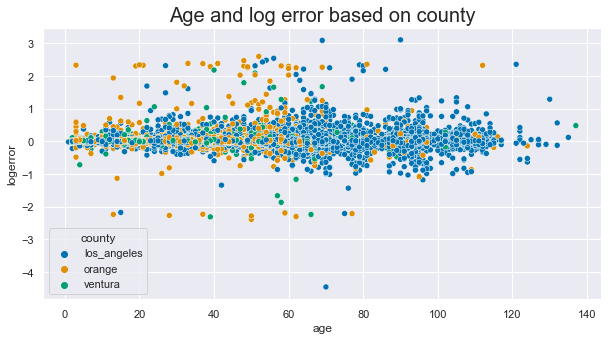

In [29]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Age and log error based on county', fontsize=20)
plt.show()

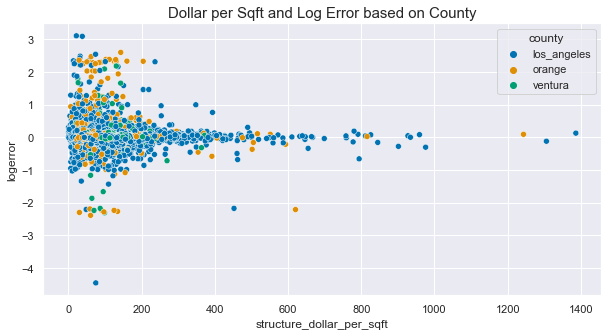

In [30]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='county', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on County', fontsize=15)
plt.show()

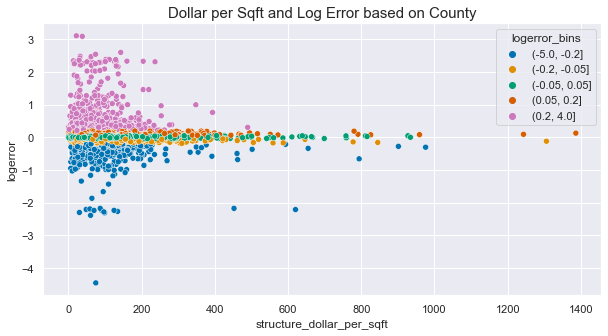

In [31]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='structure_dollar_per_sqft',y='logerror',data=train,hue='logerror_bins', palette='colorblind')
plt.title('Dollar per Sqft and Log Error based on County', fontsize=15)
plt.show()

In [32]:
#I don't intend on using log error bins so just make sure we drop it before we go. Let's press forward
train = train.drop(columns=['logerror_bins'])

Exploration Takeaways Pre-Clustering:
 - Log error is affected by property age, square footage, price per square foot, number of bathrooms, and number of bathrooms.
 - More variance in log error with cheaper houses
 - Visually appears that Orange county has the most variance in log error 
 - Heatmap suggests none of the columns (on their own) are strongly correlated to logerror.
 - Let's move on to clustering

## Clustering

#### We're going to set a = .05

Null Hypthesis: There is no difference in log error between homes based on groups of age and square footage. <br>
Alternative Hypothesis: There is a difference in log error between homes based on groups of age and square footage.

Clusters based on age property and square footage


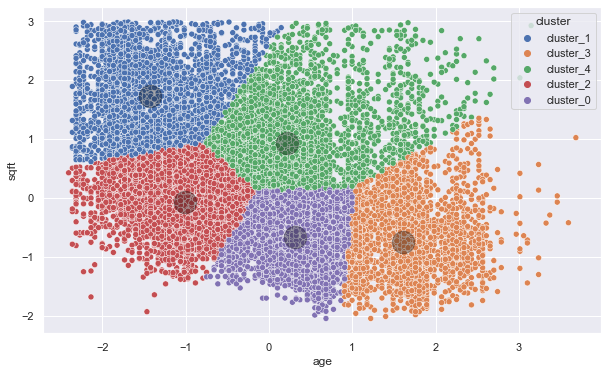

In [33]:
#Let's look at property age and square footage
X = X_train_scaled[['age', 'sqft']]
X_train_scaled, X_scaled, scaler, kmeans, centroids = create_cluster(X_train_scaled, X, 5)
create_scatter_plot('age','sqft',X_train_scaled,kmeans, X_scaled, scaler)
print('Clusters based on age property and square footage')

In [34]:
#add our predictions to train so we can test for significance
train['cluster'] = kmeans.predict(X_scaled)

In [35]:
#assign clusters
cluster0 = train[train.cluster == 0].logerror #average age, smaller houses
cluster1 = train[train.cluster == 1].logerror #young, big houses
cluster2 = train[train.cluster == 2].logerror #young, smaller houses
cluster3 = train[train.cluster == 3].logerror #older, smaller houses
cluster4 = train[train.cluster == 4].logerror #average age, bigger houses

In [36]:
#Statistically significant differences in log error means between these groups? 
from scipy.stats import f_oneway

f, p = f_oneway(cluster0,cluster1,cluster2,cluster3,cluster4)
f,p

(1.8460321206033514, 0.11696152180450685)

We fail to reject the null hypothesis, the p value of ~0.12 is not significant.

<br>

Null Hypthesis: There is no difference in log error between homes based on their longitude and latitude <br>
Alternative Hypothesis: There is a difference in log error between homes based their longitude and latitude

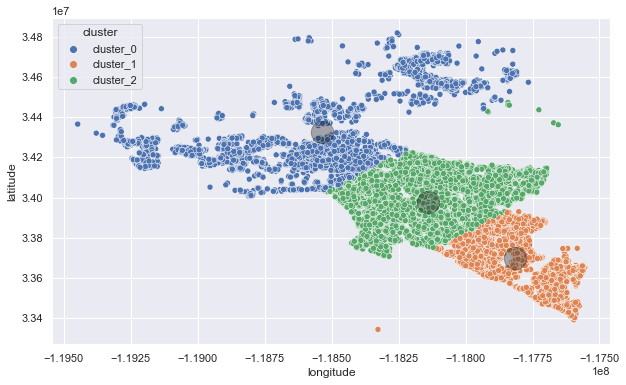

In [37]:
#why would I not have this graph, it's so pretty and may tell us something
X = train[['longitude', 'latitude']]
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 3)
create_scatter_plot('longitude','latitude',train,kmeans, X_scaled, scaler)

In [38]:
#checking the counts to assure they are reasonable.
train.cluster.value_counts()

cluster_2    12511
cluster_0     8870
cluster_1     6417
Name: cluster, dtype: int64

In [39]:
cluster0 = train[train.cluster == 'cluster_0'].logerror #this is Ventura
cluster1 = train[train.cluster == 'cluster_1'].logerror #Los Angeles
cluster2 = train[train.cluster == 'cluster_2'].logerror #Orange County

In [40]:
#Statistically significant differences in log error means between these counties? 
from scipy.stats import f_oneway

f, p = f_oneway(cluster0,cluster1,cluster2)
f, p

(7.497517670543569, 0.000555581085115141)

There is sufficient evidence to reject the null hypothesis, the p value of ~0.00 is significant

<br>

Null Hypthesis: There is no difference in log error between properties based on $ per sqft, age, and number of bathrooms and bedrooms

Alternative Hypothesis: There is a difference in log error between properties based on $ per sqft, age, and number of bathrooms and bedrooms.

In [41]:
#selecting the features we want to cluster on
X_features = train[['structure_dollar_per_sqft', 'age', 'bathsandbeds']]
X_features.columns

Index(['structure_dollar_per_sqft', 'age', 'bathsandbeds'], dtype='object')

In [42]:
#scaled versions of the features
X = X_train_scaled[['structure_dollar_per_sqft', 'age', 'bathsandbeds']]
# define the thing
kmeans = KMeans(n_clusters=5)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

#make column called cluster_house_basics
X_train_scaled['cluster_house_basics'] = kmeans.predict(X)

#centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_features.columns)

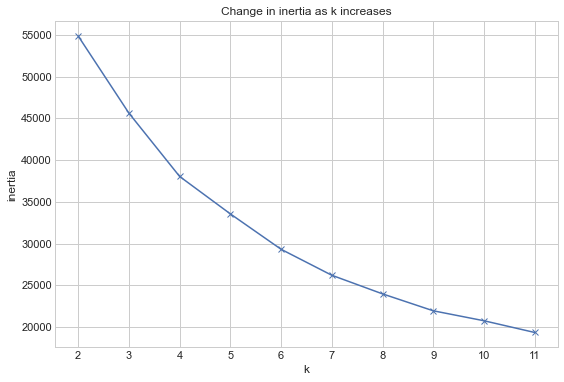

In [43]:
#inertia graph, selecting 5
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

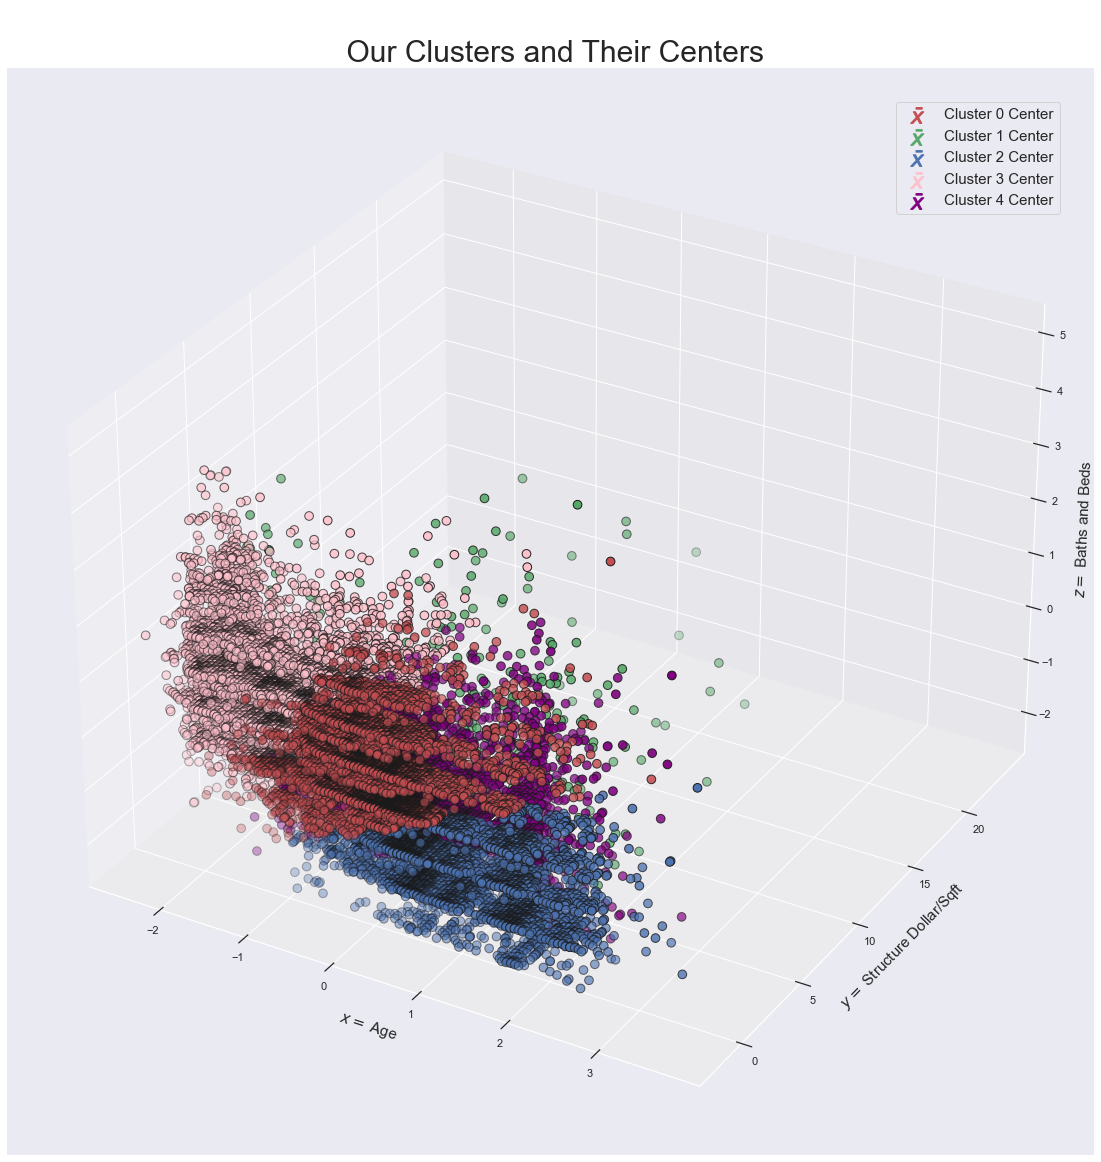

In [44]:
#%matplotlib osx
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# set x for each cluster
x0 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 0]['age']
x1 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 1]['age']
x2 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 2]['age']
x3 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 3]['age']
x4 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 4]['age']


# set y for each cluster
y0 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 0]['structure_dollar_per_sqft']
y1 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 1]['structure_dollar_per_sqft']
y2 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 2]['structure_dollar_per_sqft']
y3 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 3]['structure_dollar_per_sqft']
y4 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 4]['structure_dollar_per_sqft']

# set z for each cluster
z0 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 0]['bathsandbeds']
z1 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 1]['bathsandbeds']
z2 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 2]['bathsandbeds']
z3 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 3]['bathsandbeds']
z4 = X_train_scaled[X_train_scaled['cluster_house_basics'] == 4]['bathsandbeds']

#centroids
zero_center = centroids[centroids.index == 0]
one_center = centroids[centroids.index == 1]
two_center = centroids[centroids.index == 2]
three_center = centroids[centroids.index == 3]
four_center = centroids[centroids.index == 4]

# plot cluster 0 with center
ax.scatter(x0, y0, z0, s=75, c='r', edgecolor='k', marker='o')
ax.scatter(zero_center.age, zero_center.structure_dollar_per_sqft, zero_center.bathsandbeds, s=250, c='r', marker='$\\bar{x}$', label='Cluster 0 Center')
# plot cluster 1 with center
ax.scatter(x1, y1, z1, s=75, c='g', edgecolor='k', marker='o')
ax.scatter(one_center.age, one_center.structure_dollar_per_sqft, one_center.bathsandbeds, s=250, c='g', marker='$\\bar{x}$', label='Cluster 1 Center')
# plot cluster 2 with center
ax.scatter(x2, y2, z2, s=75, c='b', edgecolor='k', marker='o')
ax.scatter(two_center.age, two_center.structure_dollar_per_sqft, two_center.bathsandbeds, s=250, c='b', marker='$\\bar{x}$', label='Cluster 2 Center')
#plot cluster 3 with center
ax.scatter(x3, y3, z3, s=75, c='pink', edgecolor='k', marker='o')
ax.scatter(three_center.age, three_center.structure_dollar_per_sqft, three_center.bathsandbeds, s=250, c='pink', marker='$\\bar{x}$', label='Cluster 3 Center')
#plot cluster 4 with center
ax.scatter(x4, y4, z4, s=75, c='purple', edgecolor='k', marker='o')
ax.scatter(four_center.age, four_center.structure_dollar_per_sqft, four_center.bathsandbeds, s=250, c='purple', marker='$\\bar{x}$', label='Cluster 4 Center')

# set labels and title
ax.set_xlabel('\n$x =$ Age', fontsize=15)
ax.set_ylabel('\n$y =$ Structure Dollar/Sqft', fontsize=15)
ax.set_zlabel('\n$z =$ Baths and Beds', fontsize=15)
plt.title('\n Our Clusters and Their Centers', fontsize=30)
plt.legend(bbox_to_anchor=(0.975,0.975), fontsize=15)
plt.show()

In [45]:
#add predictions to our train
train['cluster_house_basics'] = kmeans.predict(X)
train

propertylandusetypeid  parcel_id       id  baths  beds  \
38772                  261.0   11347306   505981    3.0   4.0   
6386                   261.0   13993394  1711476    1.0   5.0   
36392                  261.0   14146719  2188838    2.0   4.0   
2872                   261.0   14381521  1966277    2.5   4.0   
45193                  261.0   10934407   598751    2.0   3.0   
...                      ...        ...      ...    ...   ...   
58249                  261.0   12689886  2573422    3.0   4.0   
10491                  261.0   12756637  1783941    1.0   3.0   
54469                  261.0   13936053  2635062    2.0   3.0   
74787                  261.0   12259922  1155128    1.0   3.0   
5827                   261.0   17142498  1044434    2.5   3.0   

       calculatedbathnbr    sqft  finishedsquarefeet12  fullbathcnt  \
38772                3.0  2846.0                2846.0          3.0   
6386                 1.0  1448.0                1448.0          1.0   
36392                2.0  2148.0                2148.0          2.0   
2872                 2.5  2490.0                2490.0          2.0   
45193                2.0  1446.0                1446.0          2.0   
...                  ...     ...                   ...          ...   
58249                3.0  3654.0                3654.0          3.0   
10491                1.0  1044.0                1044.0          1.0   
54469                2.0  1373.0                1373.0          2.0   
74787                1.0   962.0                 962.0          1.0   
5827                 2.5  1766.0                1766.0          2.0   

         latitude  ...  lot_dollar_sqft_bin  bath_bed_ratio cola       county  \
38772  34462144.0  ...                  0.3        0.750000    0  los_angeles   
6386   33828474.0  ...                  0.2        0.200000    0       orange   
36392  33901265.0  ...                  0.1        0.500000    0       orange   
2872   33593821.0  ...                  0.4        0.625000    0       orange   
45193  34123784.0  ...                  0.2        0.666667    1  los_angeles   
...           ...  ...                  ...             ...  ...          ...   
58249  33786759.0  ...                  0.4        0.750000    0  los_angeles   
10491  33901844.0  ...                  0.3        0.333333    0  los_angeles   
54469  33802487.0  ...                  0.3        0.666667    0       orange   
74787  33909932.0  ...                  0.2        0.333333    0  los_angeles   
5827   34237163.0  ...                  0.3        0.833333    0      ventura   

       los_angeles  orange  ventura  bathsandbeds    cluster  \
38772            1       0        0           7.0  cluster_0   
6386             0       1        0           6.0  cluster_1   
36392            0       1        0           6.0  cluster_2   
2872             0       1        0           6.5  cluster_1   
45193            1       0        0           5.0  cluster_2   
...            ...     ...      ...           ...        ...   
58249            1       0        0           7.0  cluster_2   
10491            1       0        0           4.0  cluster_2   
54469            0       1        0           5.0  cluster_1   
74787            1       0        0           4.0  cluster_2   
5827             0       0        1           5.5  cluster_0   

       cluster_house_basics  
38772                     3  
6386                      2  
36392                     0  
2872                      0  
45193                     2  
...                     ...  
58249                     0  
10491                     4  
54469                     0  
74787                     2  
5827                      3  

[27798 rows x 49 columns]

In [46]:
#logerror of the different clusters
hbcluster_0 = train[train.cluster_house_basics == 0].logerror #younger, medium, moderately expensive
hbcluster_1 = train[train.cluster_house_basics == 1].logerror #younger, smaller, cheaper houses
hbcluster_2 = train[train.cluster_house_basics == 2].logerror #slightly expensive, bigger houses
hbcluster_3 = train[train.cluster_house_basics == 3].logerror #most expensive houses, wide range of age and size
hbcluster_4 = train[train.cluster_house_basics == 4].logerror #cheaper, smaller, older houses 

In [47]:
#Statistically significant differences in log error means between these basic house features? 
from scipy.stats import f_oneway

f, p = f_oneway(hbcluster_0,hbcluster_1,hbcluster_2,hbcluster_3,hbcluster_4)
f,p

(13.72391584544265, 3.503784952974227e-11)

There is sufficient evidence to reject the null hypothesis, that is a really small p-value! (~0.00)

<br>

Null Hypothesis: No difference in log error for houses based on longitude, latitude, and age. <br>
Alternative Hypothesis: There is a difference in log error for houses based on longitude, latitude, and age.

In [48]:
#new scaled features
X_features_2 = train[['longitude', 'latitude', 'age']]
X = X_train_scaled[['longitude', 'latitude', 'age']]

# define the thing
kmeans = KMeans(n_clusters=5)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

X_train_scaled['cluster_location'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_features_2.columns)

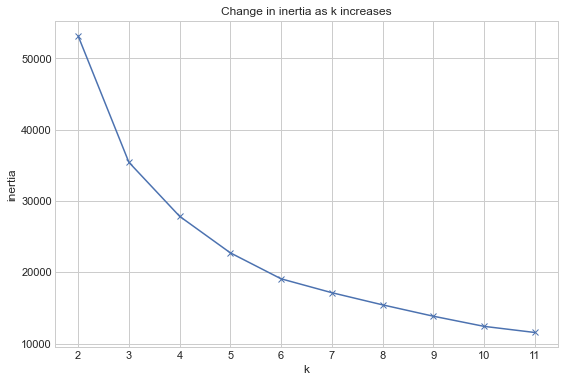

In [49]:
#inertia graph, going to pick 5
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

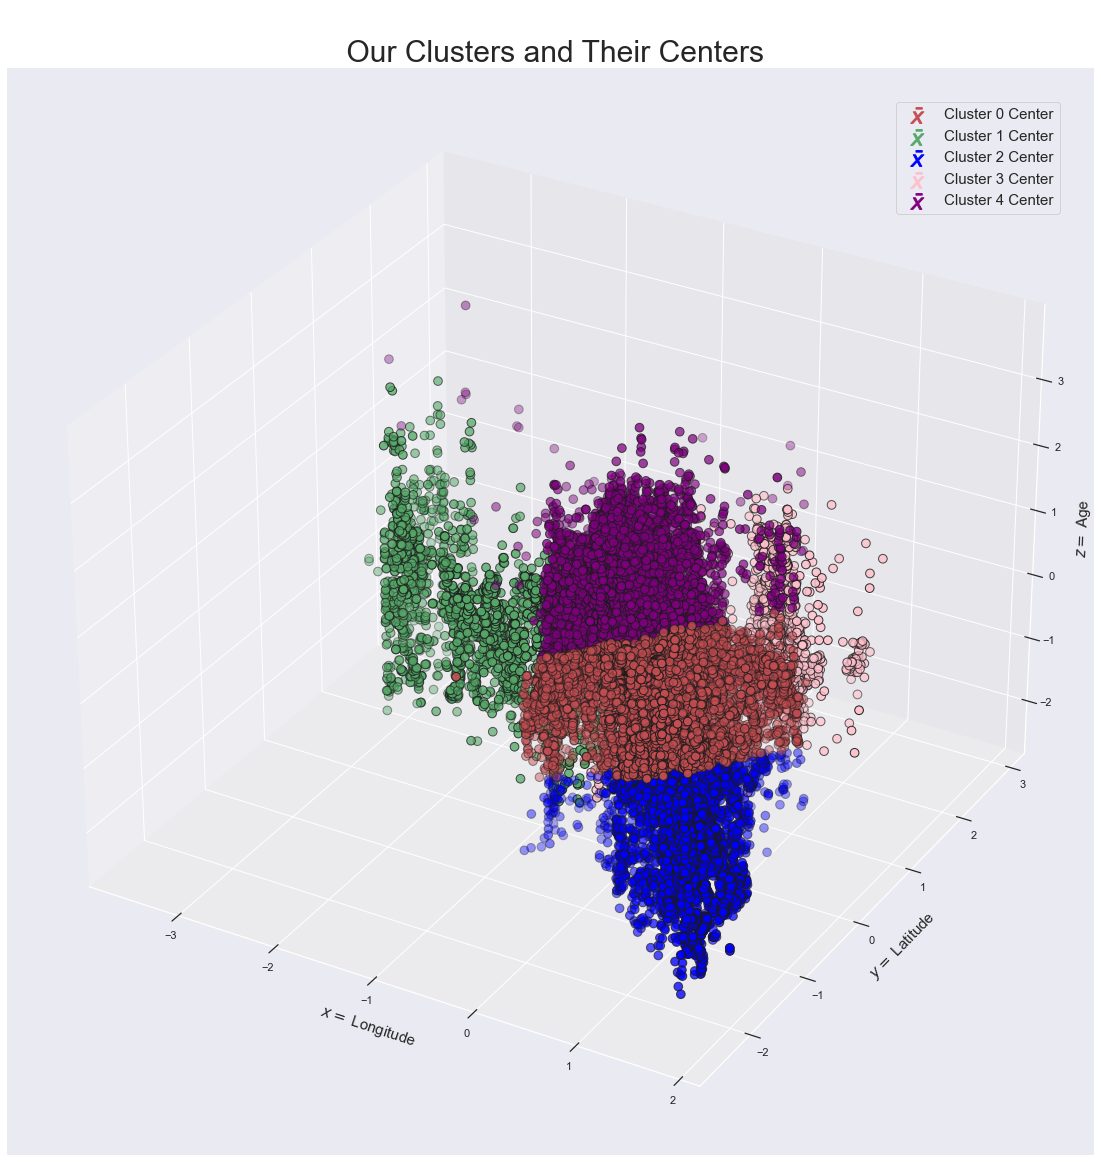

In [50]:
#visualize the clusters
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

# set x for each cluster
x0 = X_train_scaled[X_train_scaled['cluster_location'] == 0]['longitude']
x1 = X_train_scaled[X_train_scaled['cluster_location'] == 1]['longitude']
x2 = X_train_scaled[X_train_scaled['cluster_location'] == 2]['longitude']
x3 = X_train_scaled[X_train_scaled['cluster_location'] == 3]['longitude']
x4 = X_train_scaled[X_train_scaled['cluster_location'] == 4]['longitude']


# set y for each cluster
y0 = X_train_scaled[X_train_scaled['cluster_location'] == 0]['latitude']
y1 = X_train_scaled[X_train_scaled['cluster_location'] == 1]['latitude']
y2 = X_train_scaled[X_train_scaled['cluster_location'] == 2]['latitude']
y3 = X_train_scaled[X_train_scaled['cluster_location'] == 3]['latitude']
y4 = X_train_scaled[X_train_scaled['cluster_location'] == 4]['latitude']

# set z for each cluster
z0 = X_train_scaled[X_train_scaled['cluster_location'] == 0]['age']
z1 = X_train_scaled[X_train_scaled['cluster_location'] == 1]['age']
z2 = X_train_scaled[X_train_scaled['cluster_location'] == 2]['age']
z3 = X_train_scaled[X_train_scaled['cluster_location'] == 3]['age']
z4 = X_train_scaled[X_train_scaled['cluster_location'] == 4]['age']

#centroids
zero_center = centroids[centroids.index == 0]
one_center = centroids[centroids.index == 1]
two_center = centroids[centroids.index == 2]
three_center = centroids[centroids.index == 3]
four_center = centroids[centroids.index == 4]

# plot cluster 0 with center
ax.scatter(x0, y0, z0, s=75, c='r', edgecolor='k', marker='o')
ax.scatter(zero_center.longitude, zero_center.latitude, zero_center.age, s=250, c='r', marker='$\\bar{x}$', label='Cluster 0 Center')
# plot cluster 1 with center
ax.scatter(x1, y1, z1, s=75, c='g', edgecolor='k', marker='o')
ax.scatter(one_center.longitude, one_center.latitude, one_center.age, s=250, c='g', marker='$\\bar{x}$', label='Cluster 1 Center')
# plot cluster 2 with center
ax.scatter(x2, y2, z2, s=75, c='blue', edgecolor='k', marker='o')
ax.scatter(two_center.longitude, two_center.latitude, two_center.age, s=250, c='blue', marker='$\\bar{x}$', label='Cluster 2 Center')
#plot cluster 3 with center
ax.scatter(x3, y3, z3, s=75, c='pink', edgecolor='k', marker='o')
ax.scatter(three_center.longitude, three_center.latitude, three_center.age, s=250, c='pink', marker='$\\bar{x}$', label='Cluster 3 Center')
#plot cluster 4 with center
ax.scatter(x4, y4, z4, s=75, c='purple', edgecolor='k', marker='o')
ax.scatter(four_center.longitude, four_center.latitude, four_center.age, s=250, c='purple', marker='$\\bar{x}$', label='Cluster 4 Center')

# set labels and title
ax.set_xlabel('\n$x =$ Longitude', fontsize=15)
ax.set_ylabel('\n$y =$ Latitude', fontsize=15)
ax.set_zlabel('\n$z =$ Age', fontsize=15)
plt.title('\n Our Clusters and Their Centers', fontsize=30)
plt.legend(bbox_to_anchor=(0.975,0.975), fontsize=15)
plt.show()



In [51]:
#add location cluster predictions to train
train['cluster_house_location'] = kmeans.predict(X)
train

propertylandusetypeid  parcel_id       id  baths  beds  \
38772                  261.0   11347306   505981    3.0   4.0   
6386                   261.0   13993394  1711476    1.0   5.0   
36392                  261.0   14146719  2188838    2.0   4.0   
2872                   261.0   14381521  1966277    2.5   4.0   
45193                  261.0   10934407   598751    2.0   3.0   
...                      ...        ...      ...    ...   ...   
58249                  261.0   12689886  2573422    3.0   4.0   
10491                  261.0   12756637  1783941    1.0   3.0   
54469                  261.0   13936053  2635062    2.0   3.0   
74787                  261.0   12259922  1155128    1.0   3.0   
5827                   261.0   17142498  1044434    2.5   3.0   

       calculatedbathnbr    sqft  finishedsquarefeet12  fullbathcnt  \
38772                3.0  2846.0                2846.0          3.0   
6386                 1.0  1448.0                1448.0          1.0   
36392                2.0  2148.0                2148.0          2.0   
2872                 2.5  2490.0                2490.0          2.0   
45193                2.0  1446.0                1446.0          2.0   
...                  ...     ...                   ...          ...   
58249                3.0  3654.0                3654.0          3.0   
10491                1.0  1044.0                1044.0          1.0   
54469                2.0  1373.0                1373.0          2.0   
74787                1.0   962.0                 962.0          1.0   
5827                 2.5  1766.0                1766.0          2.0   

         latitude  ...  bath_bed_ratio  cola       county  los_angeles  \
38772  34462144.0  ...        0.750000     0  los_angeles            1   
6386   33828474.0  ...        0.200000     0       orange            0   
36392  33901265.0  ...        0.500000     0       orange            0   
2872   33593821.0  ...        0.625000     0       orange            0   
45193  34123784.0  ...        0.666667     1  los_angeles            1   
...           ...  ...             ...   ...          ...          ...   
58249  33786759.0  ...        0.750000     0  los_angeles            1   
10491  33901844.0  ...        0.333333     0  los_angeles            1   
54469  33802487.0  ...        0.666667     0       orange            0   
74787  33909932.0  ...        0.333333     0  los_angeles            1   
5827   34237163.0  ...        0.833333     0      ventura            0   

       orange  ventura  bathsandbeds    cluster  cluster_house_basics  \
38772       0        0           7.0  cluster_0                     3   
6386        1        0           6.0  cluster_1                     2   
36392       1        0           6.0  cluster_2                     0   
2872        1        0           6.5  cluster_1                     0   
45193       0        0           5.0  cluster_2                     2   
...       ...      ...           ...        ...                   ...   
58249       0        0           7.0  cluster_2                     0   
10491       0        0           4.0  cluster_2                     4   
54469       1        0           5.0  cluster_1                     0   
74787       0        0           4.0  cluster_2                     2   
5827        0        1           5.5  cluster_0                     3   

       cluster_house_location  
38772                       3  
6386                        4  
36392                       0  
2872                        2  
45193                       4  
...                       ...  
58249                       0  
10491                       0  
54469                       0  
74787                       4  
5827                        1  

[27798 rows x 50 columns]

In [52]:
#getting ready to test for significance
locluster_0 = train[train.cluster_house_location == 0].logerror #likely new Orange County properties
locluster_1 = train[train.cluster_house_location == 1].logerror #likely new Ventura County properties
locluster_2 = train[train.cluster_house_location == 2].logerror #Older LA properties
locluster_3 = train[train.cluster_house_location == 3].logerror #Average aged LA properties
locluster_4 = train[train.cluster_house_location == 4].logerror #a mix of new Ventura and LA? 

In [53]:
#let's see if there's a difference in logerror means between properties based on latitude, longitude, and age.
from scipy.stats import f_oneway

f, p = f_oneway(locluster_0,locluster_1,locluster_2,locluster_3,locluster_4)
f,p

(6.569094445120167, 2.7981115512176723e-05)

There is sufficient evidence to reject the null hypothesis, the p value is ~0.00

I'm going to focus on the basic house feature clusters, since it had the smallest (most significant) p value, and the highest f value. Keeping in mind an alpha of 0.05, let's see if each cluster is significant using T tests.

In [54]:
#make a population mean for all basic house features clusters
pop_mean = (hbcluster_0.mean()+hbcluster_1.mean()+hbcluster_2.mean()+hbcluster_3.mean()+hbcluster_4.mean())/5

In [55]:
#hbcluster_0 is not significant 
t,p = stats.ttest_1samp(hbcluster_0,pop_mean)
t,p

(9.456269843082534, 3.85206925815389e-21)

In [56]:
#hbcluster_1 is significant
t,p = stats.ttest_1samp(hbcluster_1,pop_mean)
t,p

(-1.8948623135703857, 0.05935946656974617)

In [57]:
#hbcluster_2 is significant
t,p = stats.ttest_1samp(hbcluster_2,pop_mean)
t,p

(3.76930430982533, 0.00016523473352112974)

In [58]:
#hbcluster_3 is not significant
t,p = stats.ttest_1samp(hbcluster_3,pop_mean)
t,p

(7.188063506072983, 7.264087166972115e-13)

In [59]:
#hbcluster_4 is significant
t,p = stats.ttest_1samp(hbcluster_4,pop_mean)
t,p

(-2.1053449089507983, 0.03532811397866545)

In [60]:
#apply basic house feature cluster predictions to train, validate, and test sets.
X = X_train_scaled[['structure_dollar_per_sqft', 'age', 'bathsandbeds']]
X_val = X_validate_scaled[['structure_dollar_per_sqft', 'age', 'bathsandbeds']]
X_test_cols = X_test_scaled[['structure_dollar_per_sqft', 'age', 'bathsandbeds']]
# define the thing
kmeans = KMeans(n_clusters=5)

# fit the thing
kmeans.fit(X)

# Use (predict using) the thing 
kmeans.predict(X)

train['cluster_house_basics'] = kmeans.predict(X)
validate['cluster_house_basics'] = kmeans.predict(X_val)
test['cluster_house_basics']= kmeans.predict(X_test_cols)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_features.columns)

In [61]:
#make dummies for all sets based on our clusters
dummy_train = pd.get_dummies(train['cluster_house_basics'],drop_first=False)
dummy_validate = pd.get_dummies(validate['cluster_house_basics'],drop_first=False)
dummy_test = pd.get_dummies(test['cluster_house_basics'],drop_first=False)

In [62]:
#rename the columns
dummy_train.columns = ['hbcluster_0','hbcluster_1','hbcluster_2','hbcluster_3','hbcluster_4']
dummy_validate.columns = ['hbcluster_0','hbcluster_1','hbcluster_2','hbcluster_3','hbcluster_4']
dummy_test.columns = ['hbcluster_0','hbcluster_1','hbcluster_2','hbcluster_3','hbcluster_4']

In [63]:
train.columns

Index(['propertylandusetypeid', 'parcel_id', 'id', 'baths', 'beds',
       'calculatedbathnbr', 'sqft', 'finishedsquarefeet12', 'fullbathcnt',
       'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidzip', 'roomcnt', 'year_built', 'structuretaxvaluedollarcnt',
       'tax_value', 'assessmentyear', 'landtaxvaluedollarcnt', 'tax_amount',
       'censustractandblock', 'logerror', 'transactiondate',
       'propertylandusedesc', 'LA', 'Orange', 'Ventura', 'age', 'age_bin',
       'taxrate', 'acres', 'acres_bin', 'sqft_bin',
       'structure_dollar_per_sqft', 'structure_dollar_sqft_bin',
       'land_dollar_per_sqft', 'lot_dollar_sqft_bin', 'bath_bed_ratio', 'cola',
       'county', 'los_angeles', 'orange', 'ventura', 'bathsandbeds', 'cluster',
       'cluster_house_basics', 'cluster_house_location'],
      dtype='object')

In [64]:
#concatenate, drop clusters we won't be using (until next time)
train= pd.concat((train,dummy_train),axis=1)
validate = pd.concat((validate, dummy_validate),axis=1)
test = pd.concat((test, dummy_test),axis=1)

In [65]:
validate.columns

Index(['propertylandusetypeid', 'parcel_id', 'id', 'baths', 'beds',
       'calculatedbathnbr', 'sqft', 'finishedsquarefeet12', 'fullbathcnt',
       'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'rawcensustractandblock', 'regionidcity',
       'regionidzip', 'roomcnt', 'year_built', 'structuretaxvaluedollarcnt',
       'tax_value', 'assessmentyear', 'landtaxvaluedollarcnt', 'tax_amount',
       'censustractandblock', 'logerror', 'transactiondate',
       'propertylandusedesc', 'LA', 'Orange', 'Ventura', 'age', 'age_bin',
       'taxrate', 'acres', 'acres_bin', 'sqft_bin',
       'structure_dollar_per_sqft', 'structure_dollar_sqft_bin',
       'land_dollar_per_sqft', 'lot_dollar_sqft_bin', 'bath_bed_ratio', 'cola',
       'county', 'los_angeles', 'orange', 'ventura', 'bathsandbeds',
       'cluster_house_basics', 'hbcluster_0', 'hbcluster_1', 'hbcluster_2',
       'hbcluster_3', 'hbcluster_4'],
      dtype='object')

In [66]:
train.drop(columns=['cluster_house_basics','cluster_house_location'],inplace=True)
validate.drop(columns=['cluster_house_basics'],inplace=True)
test.drop(columns=['cluster_house_basics'],inplace=True)

In [67]:
#drop basic house feature clusters that were NOT significant
train=train.drop(columns=['hbcluster_0','hbcluster_3'])
validate = validate.drop(columns=['hbcluster_0','hbcluster_3'])
test = test.drop(columns=['hbcluster_0','hbcluster_3'])

In [68]:
#new X_train, y_train, X_validate, y_validate, X_test, y_test
X_train = train.drop(columns=['logerror'])
y_train = pd.DataFrame(train.logerror)
X_validate = validate.drop(columns=['logerror'])
y_validate = pd.DataFrame(validate.logerror)
X_test = test.drop(columns=['logerror'])
y_test = pd.DataFrame(test.logerror)

In [69]:
#get object columns, and numeric columns. Using numeric columns to scale.
obj_cols = get_object_cols(X_train)
num_cols = get_numeric_X_cols(X_train, obj_cols)

In [70]:
#scale the X's
X_train_scaled, X_validate_scaled, X_test_scaled = standard_scale_data(X_train[num_cols], X_validate[num_cols], X_test[num_cols])

In [71]:
#let's see how many features we should use

number_of_features_list=np.arange(1,40)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train[num_cols],y_train)
    X_test_rfe = rfe.transform(X_test[num_cols])
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 20
Score with 20 features: 0.003995


In [72]:
#which 20?
cols = list(X_train[num_cols].columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 20)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train[num_cols],y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['baths', 'beds', 'calculatedbathnbr', 'year_built', 'LA', 'Orange',
       'Ventura', 'age', 'age_bin', 'acres_bin', 'sqft_bin',
       'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'bath_bed_ratio',
       'cola', 'los_angeles', 'orange', 'ventura', 'bathsandbeds',
       'hbcluster_2'],
      dtype='object')


Seems a little excessive...let's see which 5 we should use.

In [73]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 5)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
rfe_feature

['baths', 'beds', 'los_angeles', 'orange', 'bathsandbeds']

In [74]:
# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')

Var  Rank
41                bathsandbeds     1
3                        baths     1
4                         beds     1
38                 los_angeles     1
39                      orange     1
40                     ventura     2
24                      Orange     3
23                          LA     4
25                     Ventura     5
18                   tax_value     6
20       landtaxvaluedollarcnt     7
17  structuretaxvaluedollarcnt     8
5            calculatedbathnbr     9
12      rawcensustractandblock    10
22         censustractandblock    11
21                  tax_amount    12
32   structure_dollar_per_sqft    13
37                        cola    14
28                     taxrate    15
8                  fullbathcnt    16
31                    sqft_bin    17
6                         sqft    18
7         finishedsquarefeet12    19
34        land_dollar_per_sqft    20
35         lot_dollar_sqft_bin    21
29                       acres    22
13                regionidcity    23
36              bath_bed_ratio    24
27                     age_bin    25
26                         age    26
14                 regionidzip    27
10                   longitude    28
9                     latitude    29
33   structure_dollar_sqft_bin    30
44                 hbcluster_4    31
30                   acres_bin    32
11           lotsizesquarefeet    33
43                 hbcluster_2    34
15                     roomcnt    35
16                  year_built    36
42                 hbcluster_1    37
1                    parcel_id    38
2                           id    39
0        propertylandusetypeid    40
19              assessmentyear    41

Let's use our clusters, whose independent features used to make them rank pretty high, and then counties.

## Modeling

In [75]:
#establish a baseline
from sklearn.metrics import mean_squared_error, r2_score
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#logerror mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

#logerror_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

#RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('----------------------------------')

#RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))
print('----------------------------------')
r2_baseline = r2_score(y_validate.logerror, y_validate.logerror_pred_mean)
print(f'The r^2 score for baseline is {round(r2_baseline,3)}')

             BASELINE
----------------------------------
RMSE using Mean
Train/In-Sample:  0.1688 
Validate/Out-of-Sample:  0.1632
----------------------------------
RMSE using Median
Train/In-Sample:  0.1691 
Validate/Out-of-Sample:  0.1635
----------------------------------
The r^2 score for baseline is -0.0


In [76]:
#making a little df to keep track of our RMSE validates and R^2
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)}])

In [77]:
# a list of my selected features 
selected_features = ['hbcluster_1','hbcluster_2','hbcluster_4','los_angeles','ventura','orange']

In [78]:
#Our first model: LinearRegression
#create model object
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

#predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm = r2_score(y_validate.logerror, y_validate.logerror_pred_lm)
print(f'The r^2 value for linear regression is {round(r2_score_lm,3)}')

RMSE for OLS using LinearRegression:
Training/In-Sample:  0.16867738739004348 
Validation/Out-of-Sample:  0.1629901897163194
The r^2 value for linear regression is 0.003


In [79]:
#append OLS Linear Regression results
metric_df = metric_df.append(
    {
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)

In [80]:
#LassoLars
#create model object
lars = LassoLars(alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
lars.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)

#predict validate
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for OLS using LassoLars:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lars = r2_score(y_validate.logerror, y_validate.logerror_pred_lars)
print(f'The r^2 value for LassoLars regression is {round(r2_score_lars,3)}')

RMSE for OLS using LassoLars:
Training/In-Sample:  0.16880204139702645 
Validation/Out-of-Sample:  0.16321483314718824
The r^2 value for LassoLars regression is -0.0


In [81]:
#append LassoLars results
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha = 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lars)}, ignore_index=True)

In [82]:
#TweedieRegressor
#create model object
glm = TweedieRegressor(power = 0,alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled[selected_features],y_train.logerror)

#predict train
y_train['logerror_pred_glm'] = glm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)

#predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for OLS using TweedieRegressor:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_glm = r2_score(y_validate.logerror, y_validate.logerror_pred_glm)
print(f'The r^2 value for TweedieRegressor regression is {round(r2_score_glm,3)}')

RMSE for OLS using TweedieRegressor:
Training/In-Sample:  0.16870282142821041 
Validation/Out-of-Sample:  0.1630604789243506
The r^2 value for TweedieRegressor regression is 0.002


In [83]:
#append GLM results
metric_df = metric_df.append(
    {
    'model': 'GLM Model power 0',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_glm)}, ignore_index=True)

In [84]:
from sklearn.preprocessing import PolynomialFeatures

#making polynomial features to get a new set of features, I found that degree=3 yielded the best results.
pf = PolynomialFeatures(degree=2)

#fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled, and X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled[selected_features])
X_test_degree2 = pf.transform(X_test_scaled[selected_features])

#linear regresson with 2 degrees
lm2 = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm2.fit(X_train_degree2,y_train.logerror)

#predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)

#predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for OLS using Polynomial Regression (2 degrees):\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm2 = r2_score(y_validate.logerror, y_validate.logerror_pred_lm2)
print(f'The r^2 value for Polynomial Regression (2 degrees) is {round(r2_score_lm2,3)}')

RMSE for OLS using Polynomial Regression (2 degrees):
Training/In-Sample:  0.16865781752414447 
Validation/Out-of-Sample:  0.16298942803459093
The r^2 value for Polynomial Regression (2 degrees) is 0.003


In [85]:
#append the quadratic model
metric_df = metric_df.append(
    {
    'model': 'Quadratic Model',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm2)}, ignore_index=True)

In [86]:
#and the results 
metric_df

model  rmse_validate  r^2_validate
0        mean_baseline       0.163499      0.000000
1             OLS lm 1       0.162990      0.002753
2  LassoLars alpha = 1       0.163215      0.000000
3    GLM Model power 0       0.163060      0.001892
4      Quadratic Model       0.162989      0.002739

Text(0.5, 1.0, 'Residuals')

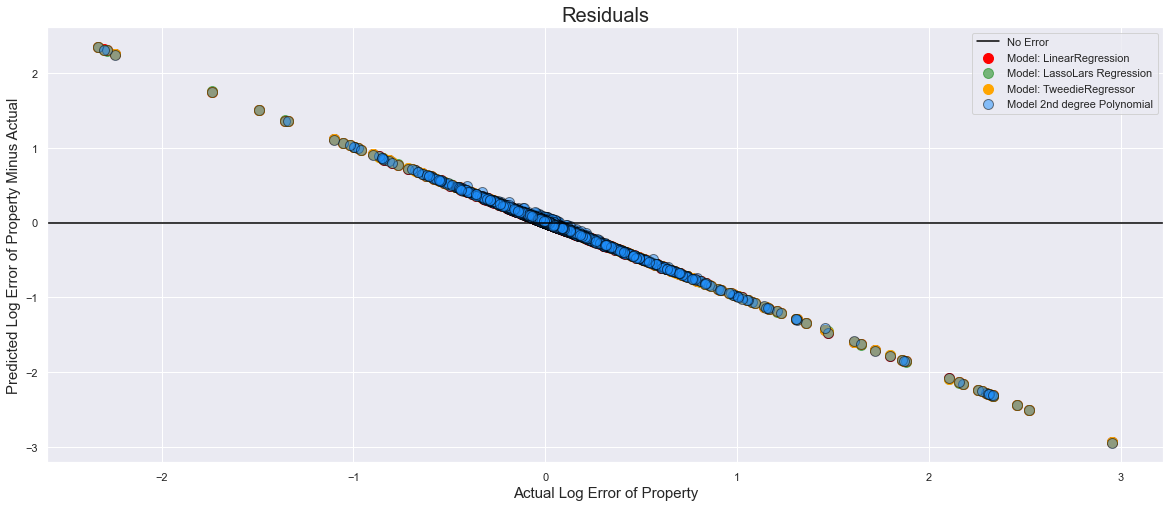

In [87]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error", color="black")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm-y_validate.logerror, 
            alpha=1, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars-y_validate.logerror, 
            alpha=.5, color="green", s=100, label="Model: LassoLars Regression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm-y_validate.logerror, 
            alpha=1, color="orange", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2-y_validate.logerror, 
            alpha=.5, color="dodgerblue", s=100, edgecolors='black', label="Model 2nd degree Polynomial")
plt.legend()

plt.xlabel("Actual Log Error of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Log Error of Property Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})

The quadratic model has the lowest RMSE, and highest r^2. We will set up a test for it.

In [88]:
#turning it into a dataframe
y_test = pd.DataFrame(y_test)

# predicting on our test model
y_test['logerror_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_lm2)**(1/2)
print('             ')
print('             Our Test Model')
print('----------------------------------')
print('----------------------------------')
print(f"RMSE for Quadratic Model \nOut-of-Sample Performance: ", round(rmse_test,3))
r2_test_score_lm = r2_score(y_test.logerror, y_test.logerror_pred_lm2)
print(f'Quadratic Model has an R^2 value of {round(r2_test_score_lm,3)}')


print('Our baseline score was 0.163')

             
             Our Test Model
----------------------------------
----------------------------------
RMSE for Quadratic Model 
Out-of-Sample Performance:  0.178
Quadratic Model has an R^2 value of 0.0
Our baseline score was 0.163


<br>

## Conclusion and Next Steps

"Mission failed---we'll get em next time!" - COD

"I didn't fail the test, I just found 100 ways to do it wrong" - B. Franklin

- My model did not beat the baseline, though it seemed promising that it would.
- Ended with an RMSE of 0.178, and an R^2 of 0.001, not a very good one anyways.

- I should try using the other clusters I made, or try clustering different features--maybe based on tax amounts and values.

